#Integrating

This is the code for integrating data on the surface of the neuron.

---

- The Map contains all points between two bifurcations (branches). 
- The Map is in lexicographic order.
- We go through the Map and call the `integrate` function on the dendritic piece selected from the Map.
- The `integrate` now counts the area of the axon continuously:
  1. Traces the end of the previous axon piece to the end of the integral,
  2. then cumulatively integrates over the current axon piece. *
  3. The integration is assisted by the `surface` function, which calls the `dist` function.

`integrate` edits the `int_cum` associated with the axon pieces in the Cell variable.

Finallly T matrix and spatial slicing is also included into this data structure.

#Included libraries, parameters, constant values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px #gui 3d scatterplot
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

pi = np.pi
sigma = 2e-6  #S/um  
sigma_ec = 3e-7 #S/um     #JÓ
capacity = .9e-14   #F/um^2 

#Functions

In [ ]:
def rotate_nov_get_MTX(nov):

  # "nov": everything is aligned to this, it will sign the electrode
  # w = ([x0, x1, ...], [y0, y1, ...], [z0, z1, ...])

  # first rotating around Y axis
  # we have to define the angle of rotation
  # we project everything to xz plane 
  # the slope of the electrode is observed 
  # slope derives from interpolation 
  nov = np.array(nov)
  eqy = np.polyfit(nov[0],nov[2],1)
  alphay = np.arctan(eqy[0])
  Ty = np.array([[np.cos(alphay), 0, np.sin(alphay)],  [0, 1, 0], [-np.sin(alphay), 0, np.cos(alphay)]])

  # rotation with matrix multiplying
  W = np.matmul(Ty, nov)
  # "nov" is in the xy plane

  # let's do a rotation around the z axis
  # we need the angle of rotation as well

  eqz = np.polyfit(W[0],W[1],1)  
  alphaz = -np.arctan(eqz[0])
  Tz = np.array([[np.cos(alphaz), -np.sin(alphaz), 0], [np.sin(alphaz), np.cos(alphaz), 0], [0, 0, 1]])

  W = np.matmul(Tz, W) # this will be "nov"
  W = list(W)
  for i in range(len(W)):
    W[i] = list(W[i])
  return [W, Ty, Tz]

def translate(nov):
  m_x = min(nov[0])
  m_y = nov[1][0]
  m_z = nov[2][0]
  for i in range(len(nov[0])):
    nov[0][i] = nov[0][i] - m_x
    nov[1][i] = 0
    nov[2][i] = 0
  return [nov, m_x, m_y, m_z]

def rotate_translate_cell(crd, Ty, Tz, m_x, m_y, m_z):
  # rotating the cell:
  crd = np.array(crd)
  # transposing:
  crd = np.transpose(crd)
  # spatial coords are cut down:
  crd1 = crd[:3]
  # diameters:
  crd2 = crd[-1]

  CRD = np.matmul(Ty, crd1)
  CRD = np.matmul(Tz, CRD)
  CRD[0] = CRD[0] - m_x
  CRD[1] = CRD[1] - m_y
  CRD[2] = CRD[2] - m_z
  CRD = np.append(CRD, [crd2], axis=0)
  CRD = np.transpose(CRD)
  # type conversion into Python list
  CRD = list(CRD)
  for i in range(len(CRD)):
    CRD[i] = list(CRD[i])
  return CRD

def find_slice_bdy(nov):
  slice_bdy = []
  for i in range(len(nov[0])-1):
    slice_bdy.append((nov[0][i] + nov[0][i+1])/2)
  return slice_bdy

def dist(v1, v2):
  '''
  Distance function
  Input: two points from R^n
  Returns: Eucledian distance of first 3 coords of two arrays in $\mu m$
  '''
  dx = (v1[0] - v2[0]) ** 2    
  dy = (v1[1] - v2[1]) ** 2
  dz = (v1[2] - v2[2]) ** 2
  return (dx + dy + dz) ** 0.5

def surface(v1, v2):
  '''
  Surface function
  Input: two points from R^n
  dist function for each points -> length
  the 4th data in each spatial point list is the diameter
  Returns: surface of a truncated cone 
  units are the same as before
  '''
  length = dist(v1,v2)  
  r1 = v1[3]/2  
  r2 = v2[3]/2  
  return (r1 + r2) * pi * np.sqrt(length**2 + (r1 - r2)**2)

def resistance(v1, v2, sigma):
  '''
  Resistance function
  Input: two points from R^n
  executes the dist method on each points-> l
  the 4th data in each point is the diameter
  Visszaad: resistance of a truncated cone
  '''
  l = dist(v1,v2)
  r1 = v1[3]/2
  r2 = v2[3]/2
  return l / (sigma * r1 * r2 * pi)  

#########################################
############ -- CUT CELL -- #############
#########################################

def cut_cell(coords, nov):
  l, co = [], []
  switch = True
  while switch:
    switch = False
    for c in range(len(coords)-1):

      for electrode in nov:  # ex. electrode = (0,0,0)
        if coords[c][0] < electrode < coords[c+1][0]:
          l.append(c+1) # indices of new coordinate
          xe = electrode
          X = [coords[c][0], coords[c+1][0]]
          Y = [coords[c][1], coords[c+1][1]]
          Z = [coords[c][2], coords[c+1][2]]
          t = (xe - X[0]) / (X[1] - X[0])
          d_new = (coords[c+1][3] - coords[c][3]) * t + coords[c][3]
          new_point = (xe, (Y[1]-Y[0]) * t + Y[0],(Z[1]-Z[0]) * t + Z[0], d_new)
          co.append(new_point) # new coordinate

    l.reverse()  # to have the right order of indices
    co.reverse() # here too

    # putting new coordinates inbtw real coordinates
    for i in range(len(l)):
      coords.insert(l[i], co[i])

    l, co = [], []  

    # execute from inverse direction:
    for c in range(len(coords)-1):
      for electrode in reversed(nov):  # ex. electrode = (0,0,0)
        if coords[c][0] > electrode > coords[c+1][0]:
          switch = False
          l.append(c+1)
          xe = electrode
          X = [coords[c][0], coords[c+1][0]]
          Y = [coords[c][1], coords[c+1][1]]
          Z = [coords[c][2], coords[c+1][2]]
          t = (xe - X[0]) / (X[1] - X[0])
          d_new = (coords[c+1][3] - coords[c][3]) * t + coords[c][3]
          new_point = (xe, (Y[1]-Y[0]) * t + Y[0],(Z[1]-Z[0]) * t + Z[0], d_new)
          co.append(new_point)

    l.reverse()
    co.reverse()
    for i in range(len(l)):
      coords.insert(l[i], co[i])

  return coords

#########################################
#########################################

#########################################
######### -- TAG INTERVALS -- ###########
#########################################

def tag_intervals(cellpart, nov):
  for i in range(len(cellpart["coords"]) - 1):
    x1 = cellpart["coords"][i][0]
    x2 = cellpart["coords"][i+1][0]

    if nov[-1] <= x1 and nov[-1] <= x2:
      cellpart["slice"].append(len(nov))
    else:
      for j in range(len(nov)):  # novel[i] = [0,0,0]
        if x1 <= nov[j] and x2 <= nov[j]:
          cellpart["slice"].append(j)
          break

#########################################
#########################################

#########################################
######## -- CALCULATE PARAMETERS -- #########
#########################################

def calculate_parameters(cellpart):
  for i in range(len(cellpart["coords"]) - 1):
    v1 = cellpart["coords"][i]
    v2 = cellpart["coords"][i+1]
    cellpart["surface"].append(surface(v1,v2))
    cellpart["resistance"].append(resistance(v1, v2, sigma))
    cellpart["length"].append(dist(v1, v2))


#########################################
#########################################

#########################################
########### -- INTEGRAL -- ##############
#########################################

def calculate_integral(cellpart, CSD, Vconst):
  # CSD is the  proper row of csd

  # previous cell compartment
  prev_cell = cellpart["prev"]
  # integraal until the prev. compartment
  if prev_cell == "CellBody":

    ## first integrating method
    prev_int_1 = 0
    prev_int_2 = Vconst

    ## new integrating method
    S = Cell['CellBody']['surface'][0]
    index = Cell['CellBody']['slice'][0]
    R = Cell['CellBody']["resistance"][0]
    prev_int_1_from_soma = S * CSD[index]
    prev_int_2_from_soma = Vconst + R * prev_int_1_from_soma
  
  else: 
    ## first integrating method
    prev_int_1 = Cell[prev_cell]["first_integral"][-1]
    prev_int_2 = Cell[prev_cell]["second_integral"][-1]

    ## new integrating method
    prev_int_1_from_soma = Cell[prev_cell]["first_integral_from_soma"][-1]
    prev_int_2_from_soma = Cell[prev_cell]["second_integral_from_soma"][-1]

  for i in range(len(cellpart["slice"])):
    C1 = cellpart["coords"][i]
    C2 = cellpart["coords"][i+1]
    S = cellpart["surface"][i]
    R = cellpart["resistance"][i]
    index = cellpart["slice"][i]

    ## first integrating method
    prev_int_1 += S * CSD[index]  #S = surface
    prev_int_2 += R * prev_int_1  #R = Resistance

    ## new integrating convention
    prev_int_1_from_soma += S * CSD[index] #S = surface
    prev_int_2_from_soma += R * prev_int_1_from_soma #R = Resistance

    cellpart["first_integral"].append(prev_int_1)
    cellpart["second_integral"].append(prev_int_2)
    
    cellpart["first_integral_from_soma"].append(prev_int_1_from_soma)
    cellpart["second_integral_from_soma"].append(prev_int_2_from_soma)

def reset_cell(cellpart):
  cellpart["first_integral"] = []
  cellpart["second_integral"] = []
  cellpart["first_integral_from_soma"] = []
  cellpart["second_integral_from_soma"] = []
  
def calculate_center(coords):
  coords = np.transpose(np.array(coords))
  center = [0,0,0]
  center[0] = sum(coords[0])/len(coords[0])
  center[1] = sum(coords[1])/len(coords[1])
  center[2] = sum(coords[2])/len(coords[2])
  return center

#Including $V_{ec}$, $V_{ec}∈𝐑^{32\times200}$
(do not open this cell, it is unnecessarly long)

In [ ]:
V_ec = np.array([[-0.10053763,0.10143564,0.30760643,0.1019654,0.25511441,0.16982058
,-0.12835216,0.07070741,0.18570578,0.29161137,0.14386936,-0.21758155
,-0.03273875,0.27122179,0.07223498,0.05829649,0.14235151,0.20000987
,-0.03548706,-0.12701311,0.32178727,0.19938529,0.13028672,0.13248864
,-0.0587714,0.43106214,0.09065297,-0.09138793,-0.01526846,0.1447417
,0.07574269,0.06473742,0.30393526,0.07901367,0.26230731,-0.17594093
,0.06460579,-0.05049609,0.41752195,0.05587358,0.32237852,0.01773552
,0.12002108,0.42047241,0.30880139,0.18976031,0.39417327,0.32543038
,0.34179691,0.19867882,0.11404035,0.05878809,0.28099451,0.1483764
,0.112325,0.53992351,0.32116341,0.44817282,0.11064574,-0.0130082
,0.21494954,0.27841035,0.15716729,0.13066538,0.45777337,0.30641427
,0.30029185,0.20997406,0.2849133,0.19430211,0.00748092,0.12309439
,0.43478796,0.41721921,0.33672734,0.16511186,0.22066793,0.21895677
,0.24919059,-0.10907545,0.14366476,0.29349241,0.06365599,0.23207668
,0.2848024,0.21528874,0.26645578,0.36142923,0.22555594,0.27709119
,0.27981901,0.19091186,-0.01774063,-0.37851004,-0.31809353,-0.54137197
,-0.93770022,-1.06035095,-1.16141785,-1.19542966,-1.12754722,-1.0977793
,-0.94124595,-1.04875695,-0.95897262,-0.80682819,-0.84733611,-0.70201678
,-0.51395611,-0.52019599,-0.41490991,-0.18488813,0.14517354,0.18122411
,-0.20271023,0.03186337,0.50359466,0.39279689,0.58650422,0.44569765
,0.64684473,0.70584805,0.7280489,0.87474294,0.68477318,0.66780652
,0.86423579,0.90242491,0.87164795,0.9356042,1.0978354,1.03567639
,1.16250221,0.90131421,0.83152907,0.88884357,0.8669092,0.604285
,0.74593203,0.77967108,0.87546369,0.66138111,0.75164481,0.72802644
,0.6625196,0.51841591,0.48067942,0.16879939,0.42151234,0.64989561
,0.41372605,0.48300497,0.58865505,0.53203148,0.36174222,0.11882335
,0.17882065,0.47682474,0.50117766,0.15193783,0.41526165,0.30040727
,0.23325607,0.09008858,0.03027639,0.1387534,0.24792894,0.17922532
,0.18545941,0.51430577,0.52745611,0.15094055,0.53956436,0.2300825
,0.29793398,0.08314825,0.20421009,0.26607326,0.210081,0.28144251
,0.03076,0.34655292,0.11516484,0.060293,0.16910401,0.27606828
,0.05985734,0.03597957,0.1153116,0.13404851,0.09596268,-0.19013535
,0.18936957,0.29064337,-0.1655853,-0.12094845,0.18658712,-0.03051054
,-0.09082871,-0.21564867],[-2.64383439e-01,-2.96752591e-01,-4.10134526e-01,-1.67045068e-01
,1.07965378e-02,-1.09987019e-01,-3.01529152e-01,8.80161301e-02
,2.48883558e-01,-2.02225219e-01,-4.55704059e-01,-3.82718164e-01
,-4.78830470e-01,-2.24411757e-01,-4.39249560e-01,-4.23429301e-01
,-4.79640007e-02,-6.97330612e-02,3.59579082e-02,6.19904277e-02
,1.70571017e-02,1.09378400e-01,-6.03305828e-02,1.33001467e-01
,4.39815286e-01,-8.86434158e-02,4.79323417e-02,5.02593942e-02
,3.18636680e-01,3.40294185e-01,-1.84094151e-01,-3.83433965e-02
,6.97924902e-01,5.51011753e-01,-5.72462923e-02,-5.83788814e-01
,1.46200407e-01,3.67769519e-02,-1.93590309e-02,9.34953071e-03
,1.01657696e-01,3.11604147e-01,-2.22592870e-01,2.87675170e-01
,4.29454303e-01,2.40452532e-02,-7.74098943e-01,2.33620112e-02
,1.64381067e-01,4.85567233e-01,-1.91275393e-01,-2.35362576e-01
,2.80197388e-01,-4.50278041e-01,-5.27362493e-01,-1.51381634e-01
,-1.73387295e-02,-1.82806348e-01,-2.97623494e-01,-2.82638725e-01
,-7.73693792e-02,6.68645623e-02,-4.13104812e-01,4.53039026e-02
,-1.35117059e-02,1.49145676e-01,-7.75966314e-02,-1.03829387e-01
,7.25280427e-01,3.25280902e-01,-2.92152324e-02,1.51071332e-01
,1.14084908e-01,-1.06489370e-01,-4.36905255e-01,-2.06261828e-01
,-1.77986522e-02,3.31883846e-02,3.53954601e-02,7.80080847e-02
,4.60999974e-01,1.39732860e-01,1.05493304e-01,2.47370127e-01
,5.82482144e-02,3.52737047e-01,-1.68555827e-01,7.72518580e-02
,6.18360776e-02,-3.36786695e-01,-8.07336386e-01,-1.15182336e+00
,-1.37217862e+00,-2.32739105e+00,-3.64239808e+00,-4.00361451e+00
,-4.81475832e+00,-5.01601168e+00,-4.84287305e+00,-4.47714332e+00
,-3.72089817e+00,-3.56623344e+00,-2.87763805e+00,-2.46421979e+00
,-1.69396022e+00,-1.34752418e+00,-1.06770985e+00,-7.92651470e-01
,-7.14726138e-01,-7.73088280e-02,-1.85402976e-01,2.04013231e-03
,2.52302818e-01,1.76567669e-01,1.42476369e-01,3.12357149e-01
,9.07639834e-01,5.31384220e-01,4.28997293e-01,4.05182478e-01
,6.39293693e-01,3.61212131e-01,3.94047171e-01,3.17502699e-01
,5.32056170e-01,1.55682641e-01,2.09758459e-01,-2.42928331e-01
,-1.93189763e-02,1.28854661e-01,-2.99616486e-01,1.64830368e-01
,-2.65344336e-01,-1.42605982e-01,3.76960455e-03,-2.47659570e-01
,-1.93935603e-02,-1.76140430e-01,-5.88004558e-01,-5.48067290e-01
,-2.62929251e-01,-6.34683306e-01,-1.06388257e+00,-7.39846058e-01
,-4.30665393e-01,-9.15582204e-01,-9.11370969e-01,-8.09977720e-01
,-1.09933821e+00,-8.72041896e-01,-1.60385909e+00,-1.35328264e+00
,-1.23680981e+00,-1.09258532e+00,-9.53443971e-01,-1.17626662e+00
,-5.17815277e-01,-7.52033912e-01,-8.73229860e-01,-1.02784216e+00
,-9.93185323e-01,-1.06406899e+00,-1.13270944e+00,-1.01746751e+00
,-9.32290576e-01,-6.11522521e-01,-1.05291033e+00,-9.08089487e-01
,-3.65661879e-01,-2.13070462e-01,-5.97990746e-01,-6.22529061e-01
,-1.62198105e-01,-2.58251691e-01,-6.43638012e-01,-1.00930292e-01
,-2.60181001e-01,1.67415524e-02,-2.08671655e-01,-5.39874015e-02
,-3.49830212e-01,-2.40280955e-01,-3.74653114e-01,-1.31769202e-01
,1.63294761e-01,-2.58934668e-01,-5.61401132e-01,-5.94557567e-01
,-6.23019256e-01,-1.06722482e-01,-5.81903203e-01,-3.96050960e-01
,-3.39993164e-01,-7.46681520e-01,-6.83918488e-01,-4.19761451e-01
,-3.57022012e-01,-7.06135743e-01,-8.86332922e-01,-1.08720882e+00],[-0.5107765,-0.73190355,-0.79603267,-0.34931865,-0.4144214,-0.41384019
,-0.37643544,-0.59986479,-0.35877184,-0.32414706,-0.50455334,-0.23285352
,0.05409447,-0.16055386,-0.26965212,-0.22568946,0.45234457,0.16090336
,-0.51544777,-0.18194157,0.05404909,-0.68035154,-0.57919599,-0.36171314
,-0.28206137,-0.40479185,-0.50387503,-0.28312271,-0.62644188,-0.74612329
,-0.45022139,-0.60094141,-0.17352309,-0.33487502,-0.53104796,-0.44008631
,-0.26039937,-0.62777193,-0.35185601,-0.58262334,-0.26365686,-0.19950673
,-0.29701549,-0.61938024,0.02171301,-0.00620225,-0.43137211,0.02332316
,0.04573505,-0.10028852,-0.55800109,-0.56376624,-0.06169367,-0.25352135
,-0.30201117,-0.04361934,-0.3501874,-0.18788496,-0.35537985,-0.26448496
,0.27331079,-0.26999089,-0.49922956,-0.48267623,0.17851995,0.15964479
,-0.26239609,-0.16147655,0.37173093,0.14365677,-0.05609121,0.43809395
,0.37221137,0.16324662,-0.37562577,-0.67668535,0.50142467,0.31475354
,-0.3477228,-0.23524527,-0.14897672,-0.21649885,-0.08350245,-0.12542169
,0.20860401,0.11252348,-0.30383755,-0.54621481,-0.59980358,-0.53504037
,-1.05585623,-1.7725613,-2.3747197,-3.35057864,-4.57437373,-4.90070215
,-4.72816653,-4.65802373,-4.95807599,-4.42292696,-3.76694618,-3.36148328
,-3.26357458,-2.6950158,-2.03413723,-1.57953913,-1.69617059,-1.29082752
,-0.31551487,-0.34159839,-0.36253259,-0.54769934,0.16566404,0.51472804
,0.01274949,0.37371184,0.74679979,0.80654801,0.66676599,1.04417676
,1.10798221,0.81644227,0.76319822,0.97232039,1.18279801,0.70283726
,0.46202495,0.58471786,0.90271348,1.03598995,0.29205784,0.54641811
,0.75927723,0.44441496,0.01180834,-0.32224344,-0.31500094,-0.52987025
,-0.44117071,-0.23943145,-0.16421681,-0.27550749,-0.52615497,-0.35082708
,-0.21392973,-0.72833418,-0.42245257,-0.30533171,-0.02306402,-0.40918156
,-0.69841666,-0.76315285,0.01657363,-0.08829318,-0.31155148,-0.53642203
,-0.38553537,-0.66545365,-0.30797268,-0.21846199,-0.15431167,-0.29069177
,-0.47039857,-0.54490841,-0.24643054,-0.47669083,-0.84515352,-0.40963802
,0.24862438,0.13985871,-0.36230435,-0.18312578,-0.07179459,-0.33331418
,-0.44895017,-0.26386473,-0.24360581,-0.58081483,-0.6828681,-0.41567518
,-0.10198459,0.13653454,-0.54978131,-0.51246818,-0.20305028,-0.20876559
,-0.51455375,-0.01987298,0.16472391,-0.51905559,-0.47588346,-0.27267815
,0.38734494,-0.44342042,-1.06228778,-0.37850845,0.24711281,-0.57956831
,-0.75892267,-0.45543875],[-5.80443103e-01,-5.37547203e-01,-7.24308166e-01,-4.69194273e-01
,-3.36184367e-01,-6.44951883e-01,-4.52109305e-01,-5.30076473e-01
,-6.75635316e-01,-1.00805188e+00,-6.80166766e-01,-5.85654208e-01
,-8.47097846e-01,-6.61579734e-01,-8.94218278e-01,-9.30710316e-01
,-2.28523938e-01,-5.26618188e-01,-5.59797768e-01,-8.39039081e-01
,-4.51501789e-01,-7.58811380e-01,-4.45051066e-01,-6.57053215e-01
,-2.17073205e-01,-3.40861151e-01,-5.32878039e-01,-5.84912490e-01
,-5.05591022e-01,-7.63257400e-01,-9.80514688e-01,-9.59726146e-01
,-5.86255472e-01,1.47233145e-01,-2.76752947e-01,-5.10144474e-01
,-3.62171335e-01,-5.71616564e-01,-5.75534962e-01,-6.09432662e-01
,-3.28855529e-01,-4.16091970e-01,-7.13158635e-01,-6.78296296e-01
,-2.57029285e-01,-1.58990602e-01,-4.66826080e-01,-5.57827578e-01
,4.61501284e-04,-2.98590037e-01,-6.73260395e-01,-7.23178933e-01
,-3.48563690e-01,-9.92672488e-02,-4.36431664e-01,-1.24244633e-03
,-2.98669925e-01,-5.87291765e-02,1.66838603e-01,-1.90141594e-01
,3.60890279e-01,4.00245059e-01,-1.12685224e-01,3.48893985e-01
,-1.27774673e-03,3.61654331e-02,-3.68329736e-02,-1.82061807e-01
,4.21440307e-01,-1.67397604e-02,2.44586574e-01,-1.41980502e-01
,-5.84345121e-02,-2.18252087e-01,-3.80691615e-01,-8.80383168e-01
,-1.72530785e-01,3.28816429e-02,8.02561153e-02,-1.28153545e-01
,-5.35771338e-01,6.49332637e-03,-1.07687333e-01,-3.91692863e-01
,-2.89561661e-01,-7.61136663e-01,-7.32648829e-01,-8.43731319e-01
,-7.47794848e-01,-1.17181818e+00,-2.40429286e+00,-3.44874562e+00
,-4.66547865e+00,-5.92245223e+00,-6.82913174e+00,-6.78718716e+00
,-7.16424857e+00,-6.40068535e+00,-6.05328378e+00,-6.11025304e+00
,-5.65314247e+00,-5.13179977e+00,-5.20470576e+00,-4.18682875e+00
,-4.18280604e+00,-3.45844691e+00,-3.24660275e+00,-2.11424321e+00
,-1.75228841e+00,-1.45425082e+00,-1.37675995e+00,-8.06865665e-01
,-3.55522829e-01,-1.56930651e-01,-4.48482288e-01,-1.87626714e-01
,4.13859797e-01,6.46233601e-01,1.69619589e-01,9.29859092e-01
,1.21611038e+00,8.44890138e-01,7.08074048e-01,1.16873324e+00
,1.22107996e+00,1.21868891e+00,1.12156732e+00,1.24034856e+00
,1.20569250e+00,9.44656873e-01,6.56230050e-01,1.04098983e+00
,9.19195751e-01,4.19335665e-01,3.15489947e-01,4.62380473e-01
,1.06056872e+00,5.71043474e-01,2.95862232e-01,4.97613956e-01
,7.80299518e-01,7.30485788e-01,-2.13373969e-01,1.98056784e-01
,2.10583666e-01,-4.30380108e-01,-4.32838243e-01,-5.35611042e-01
,-4.19350087e-01,-7.56576621e-01,-7.53530662e-01,-6.43593981e-02
,-4.55485547e-01,-7.42817769e-01,-9.66591310e-01,-6.42699418e-01
,-5.82592069e-01,-5.70790817e-01,-3.94283947e-01,-4.05622347e-01
,-1.98453173e-01,-5.04650677e-01,-8.37786386e-01,-3.35593959e-01
,-1.77811589e-01,-1.63290509e-01,-3.72169203e-01,-5.72466007e-01
,-1.87543177e-01,-5.89257528e-01,-1.00122434e+00,-4.85501084e-01
,-3.08845504e-01,-1.73162365e-01,-8.39445227e-01,-6.93897341e-01
,-3.52568003e-01,-7.04601888e-01,-9.33484260e-01,-4.02814641e-01
,-2.24807713e-01,-3.09323404e-01,-6.02833616e-01,-7.12734575e-01
,-2.90123556e-01,-2.41112889e-02,-5.24894756e-01,-5.94527255e-01
,-5.93047349e-01,-6.09964885e-01,-5.43652382e-01,-1.04624967e+00
,-3.06671231e-01,-2.65776098e-01,-7.83985164e-01,-5.70366028e-01
,-1.41962877e-01,-7.37713145e-01,-8.16549292e-01,-1.02506402e+00],[-4.98646992e-01,-5.44780797e-01,-6.71142258e-01,-7.12207136e-01
,-6.41379833e-01,-6.37587602e-01,-5.79863725e-01,-3.37643125e-01
,-5.66198677e-01,-2.74720577e-01,-2.44383996e-01,-5.73123674e-01
,-4.02237667e-01,-2.01991661e-01,-9.89952741e-01,-7.77703363e-01
,-5.79460278e-01,-8.31898203e-01,-4.81333860e-01,-7.05498794e-01
,-5.90264957e-01,-3.91769179e-01,-8.67814340e-01,-3.32346133e-01
,-2.57569919e-01,-2.44209141e-01,-8.00936256e-01,-4.39277047e-01
,-4.39008974e-01,-5.20132589e-01,-6.60134170e-01,-8.25057891e-01
,-7.97873167e-01,-1.99771862e-01,-5.73468188e-01,-3.79850626e-01
,-1.80475980e-01,-2.68042608e-01,-4.34163685e-01,-1.79960295e-01
,1.90335253e-01,4.11091207e-02,-3.12860164e-01,-4.78926650e-02
,2.88364373e-01,-1.83609329e-02,8.90329929e-02,2.13207886e-01
,-6.24219752e-01,-3.48441365e-01,-6.33582861e-01,-7.12155465e-01
,-2.67821106e-01,-2.83877216e-01,-4.03773232e-01,-4.50141596e-01
,-1.31043192e-01,-2.22401389e-02,-3.98867395e-01,-5.37421344e-01
,-3.60361176e-01,-2.82881120e-01,4.09715692e-02,-1.46349535e-01
,-3.56376810e-01,-2.83309599e-01,-2.42974125e-01,-5.13109135e-01
,-3.02962326e-01,-4.23005368e-01,-6.76228529e-01,-6.74360238e-01
,-3.55775269e-01,-5.75715982e-01,-8.34883979e-01,-1.12471310e+00
,-8.94795307e-01,-7.20865480e-01,-6.64916769e-01,-8.91851272e-01
,-7.32527467e-01,-1.51827317e-01,-3.61194719e-01,-5.90630991e-01
,-1.03509474e-01,-3.61387952e-01,-7.20282322e-01,-1.10593745e+00
,-6.75020788e-01,-1.03600051e+00,-2.25598087e+00,-3.63740658e+00
,-4.57189691e+00,-5.83477170e+00,-6.55796253e+00,-6.49525714e+00
,-6.02367436e+00,-6.26021843e+00,-6.13863378e+00,-6.11058164e+00
,-5.64925384e+00,-5.04843801e+00,-5.16512684e+00,-4.70354609e+00
,-4.12832681e+00,-3.33851522e+00,-3.40752305e+00,-3.06752964e+00
,-2.49148792e+00,-1.94544536e+00,-1.80948660e+00,-1.25724197e+00
,-8.45957446e-01,-2.21363954e-01,-5.03685319e-01,-2.15158876e-01
,1.88821534e-01,1.66537673e-01,1.50788551e-02,5.64540370e-01
,9.00399961e-01,6.51849856e-01,4.65185725e-01,1.85431977e-01
,6.37709987e-01,6.85586850e-01,9.67630043e-01,1.31476431e+00
,1.62777761e+00,1.25541096e+00,9.96502077e-01,1.24955168e+00
,1.38461328e+00,9.66619747e-01,8.17786670e-01,6.94991391e-01
,6.47275408e-01,1.00878784e+00,8.39826226e-01,1.27977664e+00
,9.65151246e-01,7.79431766e-01,7.33728665e-01,2.11542162e-01
,7.62200005e-01,7.14774183e-01,2.28995809e-01,-2.16617020e-01
,-2.14380138e-01,2.22022540e-01,2.74333651e-01,7.97528718e-03
,1.97864169e-01,-2.52384047e-02,-8.51633608e-02,-3.37271241e-01
,-9.22370540e-02,-1.03532557e-01,-3.06392546e-01,-2.81916772e-01
,-4.86468159e-01,-3.09405003e-01,-7.22068314e-01,-6.73152135e-01
,-2.64136994e-01,-3.72147398e-01,-1.44892914e-01,-9.90927675e-03
,3.89784051e-02,-6.65236992e-02,-1.03093573e-01,2.14315191e-01
,1.37144280e-02,1.51235528e-01,6.91114821e-02,-2.76995352e-01
,1.16380732e-01,-3.88005743e-03,3.20931665e-01,1.42813396e-01
,3.51620113e-01,2.88375009e-01,-3.31840450e-01,2.74135129e-01
,6.62267332e-02,-2.25218267e-02,1.31451951e-02,-8.32572083e-02
,1.79642978e-01,-1.08254028e-03,-1.33851953e-01,1.04055184e-01
,3.81443610e-01,3.26711033e-01,1.50433269e-01,1.70745807e-01
,-6.86178855e-02,-1.05307193e-01,-2.90457752e-01,-3.89509700e-01],[-9.17745451e-01,-8.31372743e-01,-1.23190357e+00,-5.47466282e-01
,-4.22422163e-01,-5.47753415e-01,-6.13364797e-01,-8.36140667e-01
,-7.29748787e-01,-6.75912208e-01,-9.41307815e-01,-8.83288552e-01
,-6.47419262e-01,-1.11946463e+00,-1.39153168e+00,-7.73992671e-01
,-5.78771790e-01,-2.15601504e-01,-4.00849095e-01,-3.98278283e-01
,-4.02916909e-01,-4.61817274e-01,-1.88694302e-02,-2.42789428e-01
,-5.15934827e-01,-7.07417345e-01,-8.85035357e-01,-7.53337868e-01
,-6.98334799e-01,-1.11198872e+00,-8.17501720e-01,-5.33959148e-01
,-9.53629962e-01,-2.66032417e-01,7.44917968e-02,-3.67175718e-01
,-2.75099388e-01,-9.71383482e-02,-2.28578850e-01,-1.66748334e-01
,1.30416982e-02,-1.04295168e-01,1.32006560e-01,-2.72588577e-01
,-3.57693854e-01,2.01628592e-01,-1.95641920e-01,-2.67816773e-01
,-1.55604234e-01,-5.96494080e-02,-1.89178192e-01,-1.19044743e-01
,-2.89408163e-01,3.62816189e-02,5.13406250e-02,-2.88626210e-02
,3.32978984e-01,1.15957267e-01,4.68818767e-01,2.89153204e-01
,4.29299293e-01,-2.42813735e-01,2.27420893e-01,1.64506545e-01
,3.88292116e-01,-3.90068346e-02,-6.20546027e-02,5.28437437e-01
,-2.01557617e-01,-3.71823187e-01,1.17965390e-01,5.10101822e-02
,-2.00997453e-01,-5.20557817e-01,-6.15801322e-01,-6.74194669e-01
,-4.03684267e-01,-6.46759174e-01,-3.78704526e-01,1.68108955e-01
,-5.49139829e-01,-4.83603834e-01,-2.59429243e-01,-3.25856602e-01
,-1.79760307e-01,-1.97379598e-01,-2.05764426e-01,-5.30883383e-01
,-1.14053021e+00,-1.53364545e+00,-2.70152088e+00,-5.16850176e+00
,-6.85488641e+00,-7.89590825e+00,-8.66865795e+00,-9.19982258e+00
,-9.24481570e+00,-8.91313317e+00,-9.00802097e+00,-8.89724608e+00
,-8.20051417e+00,-7.88827899e+00,-7.32715953e+00,-6.49747436e+00
,-5.78229526e+00,-4.96994320e+00,-4.50000342e+00,-3.82416308e+00
,-3.09887683e+00,-2.74618153e+00,-2.11942567e+00,-1.23789023e+00
,-7.69860974e-01,-3.96799106e-01,-5.03701013e-01,2.06768727e-01
,9.92669973e-01,9.02810797e-01,1.67223217e+00,1.90903029e+00
,2.17721462e+00,2.26945922e+00,2.79956728e+00,2.61284233e+00
,2.73643097e+00,2.60472462e+00,2.55572453e+00,2.46611571e+00
,2.49618470e+00,2.69212238e+00,2.49184334e+00,2.46865195e+00
,2.15739089e+00,2.12693169e+00,2.00312633e+00,2.23015303e+00
,1.87847151e+00,1.40606275e+00,2.01984934e+00,1.70885139e+00
,1.53310323e+00,1.32230583e+00,1.37667209e+00,1.12408247e+00
,1.17414556e+00,1.24525824e+00,7.39715048e-01,5.05389818e-01
,5.57807762e-01,7.43335143e-01,1.45862020e+00,1.47806566e+00
,1.00290045e+00,7.14189482e-01,8.27023336e-01,7.45317017e-01
,7.53409524e-01,6.37395158e-01,5.77520917e-01,6.17361523e-01
,5.61912207e-01,6.80617624e-01,6.86648837e-01,3.63409258e-01
,2.17729323e-01,2.86406640e-01,4.95088842e-01,-7.32894251e-03
,1.95924533e-01,-1.33361384e-02,4.71924819e-01,6.55848540e-01
,2.33909457e-01,1.79689953e-01,4.28590121e-01,9.60984736e-01
,2.20735891e-01,1.93573497e-01,1.78307962e-01,6.76728096e-04
,3.21001878e-01,3.38735134e-01,1.76095562e-01,2.21759832e-01
,2.42773612e-01,2.41262647e-01,8.78442903e-02,2.01294908e-01
,-1.22013229e-01,-2.27037677e-01,-6.86664543e-02,-1.27935944e-01
,2.97862592e-01,3.03838389e-01,1.17984074e-01,1.53316833e-01
,-2.83419214e-02,-2.18272681e-02,4.83117352e-01,-8.56712292e-02],[-2.44967507e-01,-1.32721744e-01,-8.45370598e-02,-2.99255974e-01
,-4.51904740e-01,-4.95347873e-01,-4.86980498e-01,-8.13027852e-01
,-6.68080711e-01,1.84058370e-01,-2.70498178e-01,-1.36798225e-02
,-4.33858582e-01,-4.94806085e-01,-4.17671709e-01,-6.72936674e-02
,-3.21934061e-02,-6.93573809e-02,-3.28481048e-01,-2.29134995e-01
,-5.89852256e-01,-6.03038403e-01,-4.81619322e-01,-5.93403650e-01
,-6.58794698e-01,-9.92284651e-02,1.36215230e-01,-4.97665032e-01
,-3.28787044e-01,-2.05475741e-01,-2.10224564e-01,-3.35980026e-01
,-5.09831416e-02,6.29769153e-02,-2.06822585e-02,3.66657377e-01
,-1.18105780e-01,-1.67196590e-01,-1.83138560e-01,-2.27693073e-01
,1.49360658e-02,-4.61187140e-02,1.58059896e-01,-3.00012024e-01
,-1.80452567e-02,-8.87507346e-02,-1.24959690e-01,1.64109740e-01
,-1.72496156e-01,-3.57619738e-01,-1.83738336e-01,-4.06449977e-01
,-1.62074380e-01,-2.30853386e-01,8.28006605e-02,6.48489162e-01
,8.46540142e-02,-1.43803785e-01,-3.38036260e-01,-1.16693451e-01
,-3.11023548e-01,-8.08236211e-02,-2.66023181e-02,2.22648695e-01
,3.87196597e-01,4.55283031e-01,9.49892033e-01,7.39129903e-01
,5.41050088e-01,2.15157390e-01,2.95279430e-01,-9.35502327e-02
,4.15192953e-02,2.40123933e-01,4.39383925e-01,2.24676446e-02
,6.35332959e-02,3.39587213e-01,7.63674624e-01,5.28156896e-01
,7.78452269e-01,7.02025089e-01,5.89255893e-01,4.14675380e-01
,1.86409058e-01,4.72334524e-01,-1.27094718e-02,-2.62482154e-02
,-3.28069989e-01,-4.88482794e-01,-1.50852021e+00,-3.55664338e+00
,-5.10866102e+00,-6.53198348e+00,-7.07408190e+00,-7.75622414e+00
,-8.41730902e+00,-8.83917721e+00,-8.56949304e+00,-8.48873064e+00
,-8.34353397e+00,-7.99698123e+00,-7.07516047e+00,-6.54695657e+00
,-6.71405436e+00,-5.64345391e+00,-4.71955415e+00,-4.44257734e+00
,-3.75976297e+00,-3.24802666e+00,-2.52358594e+00,-1.99670954e+00
,-1.83435424e+00,-1.06651196e+00,-2.55371983e-01,-1.52727825e-01
,1.16568960e-01,2.94621192e-01,9.16421200e-01,1.40442664e+00
,1.59020433e+00,1.99457072e+00,2.08981197e+00,2.28087116e+00
,2.37710519e+00,2.36858040e+00,2.47744112e+00,2.93485689e+00
,2.68414174e+00,2.60274812e+00,2.64639912e+00,2.54607343e+00
,2.01210300e+00,2.03543940e+00,2.18657260e+00,2.66286847e+00
,2.27391005e+00,1.80809851e+00,2.29313046e+00,1.85711531e+00
,1.49330088e+00,1.51051753e+00,1.54402364e+00,9.89220493e-01
,1.23998030e+00,1.00229818e+00,1.01785288e+00,1.21114657e+00
,1.23189037e+00,9.79570653e-01,1.06240969e+00,1.15137118e+00
,1.00518070e+00,9.29027141e-01,7.36441079e-01,6.82605894e-01
,2.10636077e-01,3.55949431e-01,7.33106906e-01,2.47155367e-01
,3.88000875e-01,4.95402500e-01,7.22714568e-01,5.72209612e-01
,-1.04080479e-01,7.03783622e-02,3.41005069e-01,5.06920630e-01
,1.26107569e-01,-1.69328450e-01,1.51725221e-01,1.91128591e-01
,-5.66298098e-02,-1.36532398e-01,-2.38426345e-01,1.10038609e-01
,-2.92694310e-01,2.51694811e-01,1.60424611e-01,8.82727202e-03
,1.05635944e-01,-3.22564123e-01,1.59857395e-01,2.84404967e-01
,-2.27686674e-01,-7.24503655e-02,4.77854529e-01,5.54948375e-01
,3.93386910e-01,3.83819978e-01,2.74025503e-01,2.82455413e-02
,1.53982302e-01,3.20293716e-01,1.82692996e-01,2.12112344e-01
,6.13657494e-02,1.26036064e-01,4.74013553e-01,4.98069990e-01],[-1.06833899e+00,-9.04297195e-01,-5.85763961e-01,-7.20588159e-01
,-1.36823790e+00,-1.15350066e+00,-8.33809902e-01,-1.10793827e+00
,-7.16314600e-01,-3.86589518e-01,-1.50548975e-01,-3.22837933e-01
,-1.63565617e-01,-7.62114867e-01,-7.91625420e-01,-8.53571162e-01
,-8.33490180e-01,-8.93330868e-01,-8.29961766e-01,-1.00910901e+00
,-1.36195881e+00,-1.23276078e+00,-6.92615999e-01,-1.20519472e+00
,-1.46522589e+00,-8.03713321e-01,-4.49532894e-01,-7.97249129e-01
,-1.03108948e+00,-1.03449252e+00,-6.13998849e-01,-7.68713886e-01
,-3.38646112e-01,-2.36675629e-01,-5.30338084e-01,-4.20427560e-01
,-3.68465743e-01,-5.07563197e-01,-3.06252568e-01,2.12396442e-01
,2.78669521e-02,5.34112374e-02,5.49839411e-01,-5.05766286e-02
,-1.62025746e-01,-1.55985618e-01,4.39277379e-02,5.16673040e-01
,4.80571974e-01,4.17433207e-01,-7.35585639e-02,-2.58079124e-01
,7.62812943e-02,1.32489480e-01,7.61574739e-01,7.12426768e-03
,2.59185988e-01,2.02912407e-01,3.02085996e-01,2.75307889e-01
,-4.92576704e-01,-6.43290955e-01,-1.50328472e-02,3.89200109e-02
,1.29012965e-01,-3.29204865e-01,1.93607230e-01,-2.80967158e-01
,-7.23369062e-01,-1.99627456e-01,5.07939257e-01,1.57931818e-01
,2.86149641e-01,-2.52510739e-01,-4.60995291e-01,-4.86816172e-02
,1.54585709e-01,4.87171950e-01,2.35554198e-02,-2.10661612e-01
,-3.37466055e-01,-2.71999510e-01,3.28728538e-01,-1.56426647e-01
,-5.31676254e-02,-1.32649919e-01,-1.45623163e-01,6.01853487e-02
,-3.90626488e-01,-1.13065896e+00,-1.76117357e+00,-2.88911054e+00
,-4.45406740e+00,-6.21162746e+00,-7.19667337e+00,-8.23953057e+00
,-9.29934430e+00,-1.02512174e+01,-1.09458289e+01,-1.06809449e+01
,-1.01490710e+01,-9.94178641e+00,-9.01195033e+00,-8.48906626e+00
,-8.17640190e+00,-7.76348122e+00,-6.20040105e+00,-5.41903890e+00
,-4.10781344e+00,-3.84129312e+00,-2.74191988e+00,-2.31920466e+00
,-1.84597556e+00,-1.05887640e+00,-3.80004174e-01,3.09435083e-01
,8.07807535e-01,1.07324472e+00,2.12804801e+00,2.29962097e+00
,2.51534244e+00,2.73874783e+00,3.10489989e+00,3.67884947e+00
,3.55171708e+00,3.48964394e+00,3.92096194e+00,3.69335983e+00
,3.20366978e+00,3.21972604e+00,3.25768796e+00,3.13123932e+00
,3.37969863e+00,2.66231615e+00,2.38463963e+00,2.71491517e+00
,2.38636677e+00,2.44744968e+00,2.29188374e+00,2.51006286e+00
,1.92421034e+00,2.28142378e+00,2.22356421e+00,1.95839967e+00
,1.93123331e+00,1.82663856e+00,1.94879908e+00,9.62033916e-01
,1.18236104e+00,1.40636318e+00,1.77218489e+00,1.53744831e+00
,1.44725493e+00,1.44307834e+00,1.21662010e+00,1.35547670e+00
,1.46502295e+00,1.22401840e+00,9.50294945e-01,1.14591539e+00
,4.71367068e-01,5.95666809e-01,9.72139227e-01,1.11313199e+00
,5.17683835e-01,1.92022567e-01,4.61755321e-01,4.63603152e-01
,8.61033397e-01,1.02497593e+00,8.48712379e-01,6.08851469e-01
,1.42368650e-01,1.70677344e-01,3.69101103e-01,1.97285540e-01
,3.33089970e-01,-9.86541082e-02,1.33145562e-01,5.47476508e-01
,2.59073156e-01,1.18250485e-01,8.81577130e-01,7.23359139e-01
,3.22161974e-01,5.83654990e-01,9.24492622e-01,6.40100277e-01
,6.52696833e-01,2.02275150e-01,3.30533905e-01,2.05714391e-01
,2.22604978e-01,7.91269242e-02,-1.96585094e-01,-1.71234410e-01
,-5.24833732e-02,-7.75320423e-02,1.24696267e-02,3.07984609e-01],[-5.47016493e-01,-8.12614783e-01,-4.75145618e-01,-3.12975200e-01
,-2.32172351e-01,-3.64751235e-01,-5.90565466e-01,-5.62148134e-01
,-1.29607338e-01,-9.55379437e-01,-7.42424707e-01,-6.41955557e-01
,-8.35777624e-01,-1.03182247e+00,-9.43798888e-01,-6.13021273e-01
,-6.04378572e-01,-5.12633654e-01,-5.61395745e-01,-7.47154341e-01
,2.01788425e-01,-1.60886214e-01,-3.03188035e-01,-4.87788387e-01
,-3.31818244e-01,5.69687238e-02,-7.71412932e-02,-7.80694914e-02
,-2.04887669e-01,-2.79392152e-01,-4.72903951e-01,-1.46729304e-01
,-1.93588776e-01,-2.69230903e-01,-2.98604296e-01,-3.83422553e-01
,-4.92555197e-01,3.46525681e-02,1.29096504e-01,-5.07965896e-01
,-9.28267396e-02,3.33015189e-01,5.04220650e-01,1.33513168e-01
,1.90947106e-01,2.13900532e-01,3.43193958e-01,3.12420788e-01
,3.04241628e-01,3.70009932e-01,-7.07506518e-02,2.23605142e-01
,2.83952793e-01,1.44797648e-01,-5.86618239e-04,3.14471877e-01
,-5.96802512e-02,-2.96820426e-01,1.20185895e-01,8.07421489e-03
,-5.35555485e-01,-4.73965444e-01,-1.67741679e-01,-2.65693969e-01
,1.29141136e-01,4.32670701e-01,-6.04248300e-02,-1.79737037e-01
,-3.36350495e-02,-2.43107093e-01,-6.45902003e-02,-1.77532765e-01
,1.53240215e-01,6.90177241e-02,-1.52049730e-02,4.70583814e-01
,2.59468288e-01,1.88440669e-01,-8.93451778e-02,-5.48679708e-01
,-5.09226708e-01,-6.04475360e-01,-4.68663832e-01,-2.65742810e-01
,-2.41529046e-01,-2.15862216e-01,-9.21728056e-01,-6.28633450e-01
,-7.93394441e-01,-8.75008697e-01,-7.65517022e-01,-1.11535251e+00
,-1.80538840e+00,-2.99241159e+00,-4.21153861e+00,-5.20657542e+00
,-6.31209926e+00,-7.10614349e+00,-7.62473997e+00,-8.18139440e+00
,-7.77770576e+00,-7.81536892e+00,-7.37351646e+00,-6.98324654e+00
,-6.25245573e+00,-5.98913590e+00,-5.81855457e+00,-4.62700963e+00
,-4.12032167e+00,-3.81511051e+00,-3.13254851e+00,-2.27491160e+00
,-1.96805660e+00,-1.53330452e+00,-1.10281482e+00,-1.02213901e-01
,1.53483897e-01,4.32088814e-01,8.97779155e-01,1.85902395e+00
,2.17015452e+00,2.32109910e+00,2.47840276e+00,2.54943417e+00
,2.76907189e+00,2.56991145e+00,3.05363686e+00,2.91204643e+00
,2.39066434e+00,2.49076305e+00,2.43059593e+00,2.24725361e+00
,2.01173701e+00,2.06831707e+00,2.26232034e+00,2.40425269e+00
,1.98925226e+00,1.74667736e+00,2.44888197e+00,1.96124710e+00
,2.15232472e+00,1.68783012e+00,1.47856548e+00,1.66597948e+00
,1.54552620e+00,1.48223379e+00,1.64324446e+00,1.63514264e+00
,1.50502395e+00,1.60249485e+00,1.47016949e+00,1.16966077e+00
,1.44266655e+00,1.54519836e+00,1.18408891e+00,1.13957126e+00
,1.55187797e+00,1.39852110e+00,9.68841190e-01,8.49580325e-01
,1.22627385e+00,7.84397520e-01,6.24073930e-01,4.44577125e-01
,5.90840870e-01,6.47384105e-01,4.23121468e-01,8.15142376e-01
,8.80536008e-01,-8.01432101e-03,2.12763729e-01,4.75097556e-01
,7.19247328e-01,4.03658383e-01,3.68731037e-01,6.42751920e-01
,7.03607357e-01,9.27796235e-01,9.20814282e-01,9.68649703e-01
,2.19952754e-01,-1.40540548e-01,4.23728509e-01,4.43385804e-01
,4.62009696e-01,4.43275314e-01,2.58357665e-01,5.77056278e-01
,4.67814478e-01,1.93955799e-01,2.14206871e-01,-2.77226321e-01
,-3.19338429e-01,-1.42515082e-01,-2.18955470e-01,-1.23426245e-01
,1.89073204e-01,-6.93150545e-03,-6.87098509e-02,1.43773832e-01],[-6.40236025e-01,-6.46186335e-01,-6.17344534e-01,-2.41951753e-01
,-2.67636571e-01,2.67920248e-02,-5.24509631e-01,-7.28466179e-01
,5.21618885e-01,-3.27571153e-01,-6.36859100e-01,-6.32822424e-01
,-1.59614857e-01,2.18443543e-01,1.73664178e-01,-1.94128425e-01
,-1.69360496e-01,5.25537191e-02,-2.63776714e-01,-3.40445549e-01
,1.33408002e-01,5.51251244e-01,5.38454410e-01,-2.55923106e-01
,1.85565304e-01,-3.21224861e-01,6.54020343e-02,6.67696788e-02
,-1.32476427e-01,-1.62018565e-01,-1.48262575e-01,-1.97262288e-01
,-4.99421900e-01,-3.59854073e-01,3.68186470e-01,8.97681047e-01
,2.72667343e-01,5.79559735e-01,3.22609454e-01,5.87323202e-01
,3.96035668e-01,4.98765049e-01,7.21129910e-01,5.65402592e-01
,9.46827274e-02,3.05431641e-01,7.34232525e-01,6.73004411e-01
,3.61471818e-01,6.16037879e-01,4.48664412e-01,5.39674424e-01
,7.95387931e-01,3.37246235e-01,2.72205649e-01,3.85918739e-01
,6.48915173e-01,5.27812574e-01,4.37765195e-01,1.57374504e-01
,1.69751893e-01,1.60831160e-01,1.99756065e-01,-2.83634604e-01
,-2.55644271e-01,-1.81970713e-01,-3.76417055e-01,-7.03826476e-01
,-4.91690791e-01,-2.88944320e-01,-2.30385452e-01,-2.04527493e-01
,-1.11234520e-01,1.66456620e-01,-1.17549835e-01,2.04626453e-01
,8.21773804e-01,7.00653477e-01,5.79633340e-01,1.52780128e-03
,7.56859494e-01,3.23981569e-01,-9.91176465e-02,-1.81209241e-03
,5.79983491e-01,3.09521317e-01,-4.09583703e-02,-1.60102944e-01
,4.81718244e-01,4.99303891e-01,7.63956637e-01,1.42298916e-01
,-6.21464569e-01,-7.73439489e-01,-1.97338778e+00,-3.24762233e+00
,-4.44189628e+00,-5.45438305e+00,-6.20839277e+00,-6.83828888e+00
,-6.47307472e+00,-7.35626664e+00,-7.13841352e+00,-6.48866975e+00
,-6.02368998e+00,-5.78178687e+00,-5.18150831e+00,-4.57678555e+00
,-4.31122894e+00,-4.18729262e+00,-3.73660407e+00,-3.58085845e+00
,-2.21351514e+00,-2.33211473e+00,-2.12832620e+00,-1.42356238e+00
,-1.10434575e+00,-3.04216836e-01,-3.21792425e-01,3.89859003e-02
,7.32415733e-01,1.34222641e+00,1.42889287e+00,1.41261189e+00
,1.53087179e+00,1.89965958e+00,2.02007119e+00,2.12237638e+00
,2.04033837e+00,1.96641774e+00,2.29304983e+00,2.21154993e+00
,1.83500286e+00,1.60617204e+00,1.10860065e+00,1.86000844e+00
,1.28861460e+00,1.60007294e+00,2.21111553e+00,2.15219517e+00
,1.52954281e+00,1.51155908e+00,1.27510339e+00,1.43155295e+00
,1.31833121e+00,1.09695359e+00,1.66882947e+00,1.39998163e+00
,1.36604197e+00,1.32757713e+00,1.44885263e+00,9.50592832e-01
,7.94654364e-01,1.05057704e+00,7.87604348e-01,1.48612039e+00
,1.01042973e+00,1.00619808e+00,8.57165168e-01,9.66734866e-01
,1.15193980e+00,1.28129875e+00,1.05130694e+00,7.94917907e-01
,7.76498873e-01,7.09787763e-01,5.83936597e-01,2.60723072e-01
,1.08546225e+00,4.76456178e-01,7.62509335e-01,7.21482746e-01
,8.43314078e-01,4.63589594e-01,2.75931049e-01,4.08424821e-01
,9.17376163e-01,8.99258439e-01,6.60431975e-01,7.75439631e-01
,5.68523284e-01,3.32095910e-01,3.11857762e-01,1.51518318e-02
,5.63936944e-01,3.47096753e-01,-1.02609749e-01,3.57106637e-01
,6.93893735e-02,1.80188456e-01,2.01647401e-01,5.37137952e-02
,5.76842437e-01,1.71976846e-01,-3.23932850e-01,-1.69687841e-01
,-4.57460624e-01,-1.53964926e-02,-5.65795765e-01,-4.16841936e-02],[-0.29920855,-0.59574902,-0.33468362,-0.25330158,-0.19139546,-0.58869322
,-0.69030629,-0.44394796,-0.23191165,-0.44961849,-0.48989188,-0.39806071
,0.06697317,0.21455048,-0.19379906,-0.25372844,-0.41865563,-0.39582649
,-0.06098032,0.05147785,-0.07975658,0.10611442,-0.18116985,0.06839576
,-0.10473724,-0.49022166,-0.58594532,-0.16128223,-0.54772071,-0.21381739
,-0.35865099,-0.56037495,-0.06254819,-0.05139217,0.04718954,0.11600407
,-0.13088396,0.08066416,-0.23551715,-0.19819477,0.49059942,0.47952263
,0.23537607,0.38518745,0.3201018,0.12061579,0.79669577,0.49689682
,0.16167823,0.26906062,0.30009207,0.31180908,0.09781001,0.21039422
,0.07366554,0.24971921,-0.22028999,-0.34807232,-0.29741524,-0.5803023
,-0.17821188,-0.27578451,0.10304159,0.11864088,0.09604654,-0.18464344
,-0.21835863,-0.27578453,-0.12531137,-0.06743536,-0.16377891,-0.25395796
,-0.23667894,0.06604181,-0.01315361,0.17753415,0.3499509,0.19100659
,-0.03525526,-0.03875632,0.22867061,0.27880127,0.42137256,0.487241
,0.44210966,0.13947549,0.26016945,0.18910444,0.32880716,0.19098637
,0.12599064,-0.02221429,0.0756433,-0.08239823,-0.3356357,-1.13276917
,-1.6661969,-2.5080371,-3.35619985,-4.38259145,-4.60397417,-4.7763245
,-5.05125653,-4.84181079,-4.71210183,-4.65241657,-4.48038037,-4.15413498
,-3.91593555,-4.3672439,-3.61601038,-3.62446396,-2.88614104,-2.4438868
,-2.1977639,-1.74395455,-1.29801654,-1.12037068,-0.26766138,-0.42773508
,0.34006113,0.83036998,0.50526423,0.83300972,0.80585332,0.66284079
,0.72081092,0.75680976,1.28079662,1.33542456,1.5407886,1.77975492
,1.70632473,1.33785391,1.53540379,1.70825748,0.90400262,1.54569575
,1.06989248,0.90794253,0.85828466,1.16950052,0.81428598,0.78329859
,0.93097336,0.22929841,0.64195224,1.04716459,1.04508264,0.69608473
,1.02257359,0.79056291,0.37558827,0.57644555,0.07311716,1.09541126
,0.60479419,0.5964476,0.38218586,0.5536464,1.18381424,1.0061238
,0.26641462,0.66215796,0.7066896,0.66616278,0.66057886,0.23980724
,0.45153677,0.55236059,0.41163785,0.35964928,0.37667392,0.40288575
,0.46384113,0.52387055,0.65768341,0.74864243,0.54948621,0.81790057
,0.93098508,0.32817154,0.47383187,0.21664243,0.7022398,0.35129802
,0.41442929,0.15863371,-0.04565456,-0.03409123,0.2829588,0.33273593
,0.07361,0.2034587,-0.1431645,-0.1783125,0.17865115,0.14695295
,-0.17624732,-0.31033486],[0.14741763,0.51703126,0.74140337,0.25609478,0.19516696,-0.27598233
,0.18146399,0.20557089,0.48411559,0.4892694,0.19835233,0.35115837
,0.37346973,0.25520599,-0.07815338,-0.01626767,0.33319337,0.51623477
,0.42618142,0.12938478,-0.2762878,0.38380983,0.23691202,0.18508293
,-0.38189828,-0.01512988,0.5878533,0.23435199,0.18763368,0.17580139
,0.08617589,0.43426253,0.17307044,0.38287588,0.55307993,0.31437404
,0.47112233,0.09824648,0.28140142,0.49872041,0.60170919,0.59584336
,0.56000747,0.74450721,0.5591966,0.4048579,0.42364115,0.82044295
,0.44842678,0.59125085,1.21941399,1.36508712,0.88600253,0.74812546
,0.54846173,0.80937487,0.64677299,0.28354241,0.76644221,0.20497602
,0.37359981,0.33723143,0.59693706,0.74935225,0.65717223,0.67754983
,0.46423703,0.66319564,0.7806412,0.91225836,1.08230824,0.64441955
,0.92958839,0.48672608,0.32126523,0.38909928,0.53292287,0.78575741
,0.45828478,0.16992345,0.12445563,-0.01658891,0.01572182,0.27431485
,0.56097236,0.9139829,0.24121442,0.38665337,0.68536429,0.93245104
,1.06079058,0.94616242,1.02349011,0.84112686,0.49531656,0.22962069
,0.40401116,-0.52074555,-1.34361485,-1.67501664,-2.2786404,-2.8445788
,-3.52108297,-3.53235738,-3.47173703,-3.68048433,-3.54476428,-3.76307937
,-3.34473269,-3.54124571,-2.97759921,-2.46514542,-2.27568323,-2.06716628
,-1.96424955,-1.24155254,-1.10577017,-0.81107939,-0.49715574,0.06184715
,0.20739653,0.6159515,0.24541956,0.71310694,0.88813141,1.17410423
,1.20559528,1.30320427,1.20474538,1.09606337,1.13351007,1.23373658
,1.43390022,1.5581831,1.37887177,1.70895627,1.64116744,1.26527594
,1.13691101,1.47429692,1.19044578,1.4511238,1.08543638,1.39552842
,1.17964865,1.08058347,0.93909157,1.47063603,1.40107143,1.39414305
,1.14162504,1.19408953,0.98901298,0.9209425,0.31940518,0.89227201
,0.72448056,0.93253829,0.59475573,0.69501584,0.84869774,0.93820474
,0.90796654,0.6593502,0.87127372,0.40227127,0.32824009,1.01379343
,0.99288988,0.27209618,0.56773635,0.54088306,0.72162601,0.6058223
,0.62293524,1.11307204,1.07902145,0.03172827,0.50667532,0.75221384
,0.57462624,0.30092514,0.36275914,0.78824244,0.49121844,0.45714734
,0.69108966,1.00723355,0.63959359,0.44072769,0.4607638,0.41759231
,0.58388192,0.35852027,0.21936653,0.27616222,0.89056274,0.85913996
,0.07083954,0.07484452],[0.51453033,0.73219992,0.95249023,0.48539244,0.47257318,0.25970344
,0.52640913,0.68121846,0.60833058,0.67405445,1.02378357,0.85584789
,1.11617603,0.51859644,0.80474367,0.5780295,0.61653634,0.6615452
,0.69512646,1.0936561,0.87842489,0.8818142,0.80661965,0.40236438
,0.51128178,0.65820201,0.69743256,0.78281484,0.50741835,0.76755827
,0.74696019,0.7622109,1.00251929,0.45789083,1.0562386,1.04940488
,0.96785322,0.91287479,0.83142732,0.64684182,0.79667202,0.92373965
,1.00636966,0.62921744,0.72933167,0.51415815,0.49022528,0.6932622
,0.43050978,0.88464171,1.13417642,1.23194713,0.74426982,0.5640714
,0.87228949,1.32507823,0.99635559,0.58113186,0.80600791,0.90682882
,0.94589707,0.60949094,0.38181398,0.65728597,0.52174759,0.80438596
,0.94794925,0.53201721,0.52976902,0.18748182,0.57102772,0.39202261
,0.74517904,0.7763692,0.78644749,0.66111988,0.73289142,0.93539315
,0.78391028,0.50597174,0.88228601,0.55715209,0.75798772,0.39582362
,0.6139835,0.36068012,0.27289868,0.33042023,0.17154295,0.43296351
,0.99439795,0.72153464,0.86625719,0.68941376,1.19746421,0.88571288
,0.95585345,0.67114875,0.07978674,-0.2060691,-0.46777784,-1.0206105
,-1.09946089,-1.02126737,-1.48189644,-1.59956984,-2.32760086,-1.66622281
,-2.12549162,-2.11875643,-1.7600503,-1.60334891,-1.61604009,-1.52333348
,-1.2462506,-1.18524874,-0.78550187,-0.3727342,-0.28827751,-0.21386081
,0.05752169,0.56848904,0.59196047,0.82611764,1.04209109,0.60750235
,1.03998837,1.48078976,1.57400819,1.24833249,1.60851533,1.41823489
,1.16045396,1.37009082,1.29734871,1.34682996,1.36541594,1.52180329
,1.45303593,1.39493832,1.32138264,1.57524411,1.89402869,1.57090448
,1.38640735,1.5427291,1.15334011,1.43391381,1.17299472,1.06356207
,0.7646189,0.6413325,1.20457673,0.93378928,0.65999698,0.81609131
,1.16432867,0.99133741,1.19777508,0.87601187,0.86481388,1.14043823
,1.68868265,1.62911583,1.29674943,0.69116141,0.66771517,0.93011383
,0.83223349,1.12430449,1.13173412,0.84364776,0.73785904,0.86931435
,0.69233147,0.79042628,0.41926604,0.49597451,0.32582136,0.07818006
,0.65512983,0.07465138,0.25559337,0.31624612,0.04336113,0.55063283
,0.58097571,0.60867864,0.32802193,0.23579123,0.15691318,0.70868804
,0.27530009,0.37722664,0.27827272,0.01897997,-0.1711716,0.03533227
,-0.26970489,0.11469912],[1.27741180e-01,1.73906748e-01,2.18610960e-01,4.84875033e-02
,1.56701610e-01,2.46628825e-01,8.14183721e-02,1.34662299e-01
,8.89451464e-02,5.70105497e-01,3.15967215e-01,2.86189508e-01
,6.04909317e-02,3.14903072e-01,1.05149589e-01,4.87002425e-01
,5.54723288e-01,3.98980560e-02,-2.69450142e-01,6.46764537e-03
,3.16015168e-01,1.00332312e-01,-3.18255416e-02,4.21493040e-01
,1.12221786e-01,-4.23639103e-02,-1.95230132e-01,2.52026882e-01
,-5.21237936e-03,-1.29421023e-01,-4.88697986e-02,2.72639642e-01
,1.57143068e-01,1.45833360e-01,-4.48311850e-02,8.33204601e-02
,9.58952631e-02,-3.62617703e-01,-4.12189425e-02,-3.29263287e-01
,-4.04872501e-01,-2.62317360e-01,-4.70879644e-02,1.47205913e-01
,-4.77796166e-02,3.81534963e-01,3.70432461e-01,1.29571578e-01
,-6.86248962e-02,2.51571423e-01,5.30547683e-01,5.17966171e-01
,3.64213695e-02,2.60611125e-02,1.78399582e-01,3.88543855e-01
,4.87202678e-01,2.90265540e-01,9.49225998e-02,3.69356112e-01
,1.18666408e-01,2.42675511e-02,3.96003278e-01,-1.70102664e-01
,2.87602016e-01,8.92212833e-01,4.12679599e-01,1.96842319e-01
,-1.91291669e-02,4.00495547e-02,2.40223027e-01,3.58880253e-01
,3.90648883e-01,4.06157939e-01,3.68873849e-01,4.45002850e-01
,3.32042824e-01,2.97940150e-01,5.97448823e-02,2.85328104e-01
,2.79397669e-01,-5.78648148e-02,7.07541348e-02,4.03116515e-02
,4.26946833e-01,1.51498397e-01,5.62017437e-01,5.80290247e-01
,2.80974027e-01,1.54231567e-01,-1.24882909e-01,4.78981392e-01
,6.42665590e-01,5.14659166e-01,7.89204082e-01,9.88408828e-01
,1.24478007e+00,9.88640127e-01,6.75969577e-01,7.63365227e-01
,9.06183954e-02,1.04074659e-01,-2.57595083e-01,-6.24036783e-01
,-1.05612524e+00,-1.70639115e+00,-1.88594138e+00,-1.92040247e+00
,-2.19578126e+00,-2.19375901e+00,-1.75888884e+00,-2.15919289e+00
,-1.88796962e+00,-1.88293301e+00,-1.54867708e+00,-1.72359930e+00
,-1.77929549e+00,-9.63203532e-01,-8.21796489e-01,-9.23402997e-01
,-8.70197347e-01,-4.10918762e-01,-1.08153626e-01,-3.27773359e-01
,-1.46603597e-01,-1.21329496e-01,-8.69564698e-02,1.05642170e-01
,4.16827271e-01,4.03319918e-02,1.42129968e-01,3.27751584e-01
,2.40293932e-01,5.85709278e-01,3.03207766e-01,5.56784895e-01
,3.22168061e-01,5.07074593e-01,7.79644449e-01,8.78647165e-01
,7.61135742e-01,7.63452643e-01,4.12942847e-01,8.01103963e-01
,9.37054808e-01,4.53178419e-01,1.93901112e-01,3.64982205e-01
,8.26151706e-01,5.37023344e-01,6.56348251e-01,3.62623701e-01
,3.79894202e-01,2.14949321e-01,2.82822259e-01,9.41294615e-02
,3.70377638e-01,5.33190360e-01,1.75627402e-01,-2.62839409e-02
,3.90550850e-01,2.69586342e-01,5.36604217e-01,5.35950071e-01
,5.63733848e-02,2.98671299e-02,4.30194491e-01,5.51690277e-01
,6.86887718e-01,3.30972908e-01,5.08335416e-01,1.97781532e-01
,2.48952011e-01,3.85173559e-01,4.13532916e-01,1.44792063e-01
,4.84533774e-01,1.52881516e-02,-1.04265808e-01,7.61661129e-02
,2.48124068e-01,4.65105994e-01,1.16880716e+00,9.99192255e-01
,7.83318293e-01,3.76014655e-01,3.89084457e-01,4.22867326e-01
,3.95571560e-02,3.34178677e-01,-6.89028908e-04,3.57830763e-01
,5.52802721e-01,7.15259240e-02,3.05588950e-01,2.55996438e-01
,1.07331972e-01,1.00140691e-01,-1.31615760e-01,-1.97844114e-01],[7.38590237e-01,5.19132290e-01,7.13252607e-01,4.34191823e-01
,4.10275162e-01,-2.46806639e-01,-1.75023113e-01,1.00913661e-01
,-6.23071657e-02,8.09296401e-02,1.72253895e-01,1.44286226e-01
,-3.56682062e-01,-4.03794981e-01,-1.86775130e-01,-3.32236189e-01
,3.24262201e-01,1.93229064e-01,9.63337350e-02,2.34910100e-02
,-2.31326113e-01,-5.00739756e-01,-1.13636771e-01,-1.54535784e-01
,-1.01204761e-01,1.64514100e-01,-7.82351303e-02,-1.79047891e-01
,4.81374312e-02,-8.08009732e-02,-1.07304663e-01,-4.22618745e-01
,-4.37661890e-01,-5.53510223e-01,-1.76043796e-01,-1.62546293e-02
,-1.54817389e-01,-2.21619580e-01,4.15116259e-02,-4.59697838e-02
,-4.75033245e-01,-2.09223608e-01,-1.51705853e-02,-3.52905378e-01
,5.92068329e-02,4.55131613e-01,-2.87961594e-01,-4.27730035e-02
,-8.95556225e-02,-1.72321393e-01,-2.88143400e-01,-1.67518777e-01
,-2.01856965e-01,-4.55911265e-01,-2.13152705e-01,3.94893425e-01
,7.75835366e-01,5.61720614e-01,4.60278528e-01,4.64504290e-01
,8.45513016e-01,1.75048392e-01,3.45019263e-01,2.06313261e-02
,-1.82292898e-01,6.61549878e-02,-4.72207785e-02,-1.42130369e-01
,-1.28064289e-01,-3.02138589e-01,3.75714459e-01,4.65514233e-01
,1.24400627e-01,-5.83541493e-02,8.43285961e-02,-1.34478474e-01
,4.60663971e-01,7.30506505e-01,2.27582869e-01,1.80558355e-01
,4.49849884e-01,1.21355379e+00,4.96315310e-01,1.03463929e+00
,5.80360668e-01,6.69330843e-01,3.61937566e-01,3.57356180e-01
,4.15427234e-01,6.32406573e-01,9.90399476e-01,8.54737549e-01
,6.59595681e-01,1.18649659e+00,2.05044013e+00,2.46238391e+00
,2.13592803e+00,2.38226788e+00,2.49477007e+00,2.28658200e+00
,2.35865651e+00,1.99530012e+00,1.40076188e+00,9.13221644e-01
,9.67784744e-01,3.35743825e-01,1.61834637e-01,2.83441768e-01
,3.44789041e-01,-4.40641472e-01,1.67126858e-01,-9.61094811e-02
,-5.48476849e-02,-5.71967031e-01,-6.49219277e-01,-1.22563733e+00
,-9.62892081e-01,-1.22033504e+00,-8.48636979e-01,-8.72875334e-01
,-4.15300732e-01,-9.02708543e-01,-6.77106192e-01,-6.62009713e-01
,-2.45557195e-01,1.74887075e-03,-2.61874270e-01,-4.00596363e-01
,-1.76366040e-01,3.75396065e-01,4.88446085e-01,6.17509378e-01
,4.59878124e-01,4.54962225e-01,4.82550541e-01,-2.10732473e-02
,2.47983045e-01,3.71901260e-01,4.25331066e-01,4.24100712e-01
,4.92720782e-01,1.27159629e+00,5.85908118e-01,3.91286638e-01
,6.49863245e-01,7.35456341e-01,1.59699573e-01,8.82282492e-02
,6.74756113e-01,7.69636202e-02,6.89786758e-02,4.73445712e-01
,3.66257224e-01,7.05860288e-01,1.67048697e-02,-1.55778305e-01
,-2.17188801e-02,5.26398241e-01,7.49432739e-01,5.17866518e-02
,5.16838894e-01,1.02548121e+00,7.73984824e-01,5.69044597e-02
,2.87425993e-01,2.75992244e-01,1.15465250e-01,2.26658306e-01
,9.44815243e-02,-1.35751554e-01,5.45987822e-02,4.63635262e-01
,7.66267605e-01,3.06089446e-01,8.63837591e-01,1.06859987e+00
,5.07791526e-01,4.81946677e-01,8.28720667e-01,9.78725191e-01
,3.59752991e-01,3.03817047e-01,8.95370003e-01,1.09520674e+00
,8.85880765e-01,1.23882158e+00,3.83645373e-01,1.56723895e-01
,5.23851230e-01,3.19093018e-01,2.07124929e-01,3.16343891e-01
,3.35722787e-01,-2.07248219e-01,1.77671715e-01,5.83945771e-01
,3.40183565e-01,6.20427280e-01,8.97027011e-01,6.75456422e-01],[0.53760558,0.53988609,0.70100346,0.72956895,0.51880092,0.75868228
,0.96630826,0.48529448,0.30918021,0.8330486,0.64911901,0.64635231
,0.25007505,0.43166589,0.5504793,0.56321887,0.66516684,0.66927983
,0.33563064,0.58655776,0.6353102,0.68591443,0.70357007,0.623141
,0.62402248,0.80496917,0.77423678,0.23724982,0.30261515,0.8254283
,0.98531051,1.22344477,0.68635962,0.24020221,0.26077164,0.70669239
,0.59650724,0.97092621,0.75978586,0.49809327,0.53727503,0.51488538
,0.42881463,0.53663724,0.74385153,1.2138832,0.5349509,0.72795638
,0.80773932,0.79998305,0.45475079,0.47256737,0.14259395,0.07789023
,0.35437573,0.78958942,0.82069727,0.91868907,0.74104145,0.76780737
,0.86454152,0.7895118,0.97511497,1.00684068,0.70326979,0.69558804
,0.58733898,0.54666921,0.3147127,0.27378263,0.5409661,0.71260464
,1.07758557,0.70583646,0.21803367,0.25823456,0.43974383,0.37324162
,0.68682542,0.3336855,0.26533528,0.53179364,0.80376795,0.75069607
,0.55882611,0.53176411,0.09386527,0.27310396,0.19845626,0.11862749
,0.55887327,0.75643876,0.95206344,1.01194971,1.23457757,1.21034935
,1.02369993,1.69824344,1.96691878,1.78059999,2.21575501,2.2747071
,2.03411083,1.45755485,1.4906553,1.44661764,1.34768725,0.69361457
,0.46012432,0.52002454,0.21002589,-0.12614138,-0.35945174,-0.41015003
,-0.4241263,-0.71643489,-0.63534636,-0.8374942,-0.7481415,-0.85839238
,-0.49655313,-0.15020076,0.10498458,0.18511765,0.03062543,-0.25362906
,0.01687723,-0.375347,-0.25852284,-0.14055427,-0.13708447,0.47166764
,0.31173435,0.34518281,0.39027226,0.38351839,0.34631906,0.1250105
,0.55906969,0.16512836,-0.21634007,0.24124427,0.76645088,0.41783326
,0.46581981,0.36346057,0.17518773,0.36664405,0.60967553,0.30340894
,0.75921243,0.32836648,0.07334186,0.5971139,0.43230099,0.34653672
,0.43218779,0.80589185,0.56439876,0.58384405,0.52032866,0.51226713
,0.25682762,0.22732302,0.23142106,0.287949,0.21381737,0.4950207
,0.3764848,0.22505941,0.16825655,0.37872768,0.65710323,0.52091269
,0.31479438,0.32550899,0.02304419,0.15927293,0.36671266,0.41769887
,0.19682745,0.30847806,0.52825995,0.1975585,0.20433047,0.36177802
,-0.08708956,0.13831785,0.05371618,-0.33761922,0.07382833,0.09025688
,-0.12514749,-0.04872051,0.28229342,0.07603909,0.08662739,-0.06833466
,0.04762374,0.23588883],[-1.88295026e-01,1.48882815e-02,3.29724379e-01,1.30845843e-01
,-2.39613295e-01,-9.75110494e-02,3.77991406e-01,-4.57511263e-03
,-3.90484253e-02,2.08751710e-01,-2.52308878e-02,-4.39385117e-01
,-2.26483139e-01,-5.67462976e-02,-1.91763900e-01,-4.01019575e-02
,-1.58344416e-01,1.95011464e-01,2.97273401e-01,3.94579340e-01
,2.57456376e-01,1.17919060e-01,9.28936540e-02,6.48460794e-02
,5.96377566e-01,6.39859309e-01,-9.86727381e-02,-3.59308777e-02
,-1.74212628e-02,3.94992515e-01,1.86060914e-02,4.68283994e-02
,6.08593785e-02,7.71171226e-02,1.01990491e-01,4.14829515e-01
,4.97678483e-01,4.98878597e-01,-1.60023716e-01,4.19635997e-02
,6.13832435e-02,-1.03690744e-02,-4.48802932e-01,1.70980640e-01
,-7.97890664e-02,1.93899312e-01,-1.59855599e-01,-7.81176845e-02
,3.12385313e-01,4.66769246e-01,8.20929813e-02,1.73173574e-01
,5.29753398e-01,5.34874987e-03,-1.12960487e-01,1.88323844e-03
,5.62118266e-02,1.03685634e-01,-4.06094317e-03,9.00998419e-02
,-2.50227482e-01,-1.05470670e-01,-1.78664436e-01,3.75658171e-01
,3.51802152e-01,-3.88107214e-01,-2.52802161e-01,4.84923501e-03
,6.13373707e-02,1.60341245e-01,1.02940051e-01,-4.33453715e-02
,-3.43475283e-01,-2.40771195e-01,-2.55851804e-01,5.11852421e-02
,1.12132526e-01,-1.39779590e-01,4.50179527e-02,6.62351584e-03
,3.87895543e-01,-1.55385711e-01,2.28123415e-01,-2.44873867e-01
,-4.06339987e-01,3.10794150e-02,9.94543774e-02,6.37136834e-02
,2.38099767e-01,9.31327720e-02,2.31550243e-01,1.22107522e-01
,8.86672955e-01,5.48189097e-01,4.53787892e-01,6.22404065e-01
,4.60432229e-01,8.98888119e-01,8.51895490e-01,1.13608397e+00
,1.72508768e+00,1.74988708e+00,2.18444524e+00,2.08496447e+00
,1.88677049e+00,1.71835060e+00,1.02213795e+00,1.25500687e+00
,1.34975031e+00,1.35490078e+00,1.04790410e+00,9.90541755e-01
,1.01420085e+00,7.15936352e-01,1.05794959e+00,8.72114916e-01
,5.32336186e-01,6.69230862e-01,4.31660227e-01,3.96951108e-01
,3.86403276e-01,7.47690542e-02,-9.31243822e-02,-1.88851067e-01
,-1.68120991e-01,2.60614098e-01,-2.31478525e-01,9.15493937e-02
,3.26840709e-01,-2.30935374e-01,1.05159094e-01,5.67103432e-01
,6.16216293e-01,7.50890323e-01,1.73660819e-01,7.13970129e-01
,1.71416216e-01,3.02667249e-01,6.77590043e-01,6.66822294e-01
,5.56836111e-01,3.10335013e-01,3.84422080e-01,8.98337056e-01
,1.07919629e-01,3.75849901e-01,5.95371105e-01,3.90806899e-01
,5.43799888e-01,7.25242392e-01,1.78527297e-01,4.59910838e-01
,2.07518577e-01,2.26618467e-01,1.18016587e-01,-3.42769423e-01
,-1.67348505e-01,1.95587308e-01,-3.79222193e-01,-6.62122217e-03
,1.22809685e-01,3.42937087e-01,3.40884382e-02,-7.77939066e-02
,9.51930119e-02,2.16749710e-01,3.12877629e-01,7.91721566e-01
,5.47620741e-01,5.47359938e-01,1.78973327e-01,-2.31978975e-01
,5.63135444e-01,2.85861129e-01,-1.26050523e-03,1.14215596e-01
,-2.76949093e-01,-3.93365314e-01,-2.86807172e-01,-8.94860013e-01
,-8.06116470e-01,-6.98691805e-01,-1.18440384e-02,7.90714647e-02
,-3.75466397e-01,2.28833030e-02,1.78296615e-02,6.09163144e-02
,-2.36372676e-01,2.10000645e-01,-3.22819772e-01,-5.22373879e-01
,-2.18806288e-01,-1.61003809e-01,4.12672184e-01,9.88567500e-02
,-2.01668077e-01,-4.44939596e-01,-3.10826107e-01,-2.36937470e-03],[1.04805597,1.05962654,0.8321894,1.09282348,1.03793946,1.02107426
,0.7785933,0.798579,0.74121984,0.4092496,0.52832361,0.52829434
,0.61088082,0.52458862,0.48664332,0.64118642,0.8924412,0.59282898
,0.65537904,0.43577341,0.37724383,0.59185402,0.58395229,0.9083854
,0.54612357,0.76726302,0.76893868,0.4863436,0.86902348,0.71346699
,0.61363155,0.23060999,-0.14791341,0.53108354,0.51050044,0.31495632
,0.24612307,0.56660608,0.51661835,0.26719926,0.24110973,0.54433392
,0.58894166,0.76896977,0.47816433,0.52696775,0.88514868,0.48923337
,0.86485784,0.50219306,0.71191996,0.4269255,0.08982925,0.41177327
,0.32895426,0.44693535,0.70777821,0.20203532,0.27885224,0.23028309
,0.34377314,0.67868023,0.56605581,1.04217599,0.53356953,0.34759714
,0.57841907,0.68055629,0.79026341,0.66472465,0.6221753,0.84323386
,0.55264616,0.92862488,1.35838946,0.7616155,0.87867631,1.1347633
,1.05920698,1.00866552,0.81267146,0.54203733,0.42495075,0.88127506
,0.57091321,0.61454652,0.76648175,0.58505556,0.60781007,1.1976535
,0.98918071,1.18427382,1.05994312,0.90296431,0.9981901,0.83775515
,1.20200607,1.31410268,1.53198915,2.02802647,1.93506937,2.46457774
,2.63882718,2.61883373,2.13427402,2.53437156,2.77585216,2.56244091
,2.63315302,2.23825568,2.22629703,1.70421953,1.58134463,1.66070372
,1.75899387,1.43176293,1.58678749,1.29641542,0.78488129,0.83447041
,0.6173161,0.87312114,0.87023531,0.75888107,0.72385972,0.51369743
,0.82636351,0.56138595,0.85113359,0.30772619,0.48698148,0.84527561
,0.10566202,0.41987247,0.59341086,0.56454957,0.50610402,0.16309486
,0.8158702,0.73668994,0.56105422,0.65460533,0.32266137,0.24683554
,0.22088508,0.08859122,-0.09726534,0.14292725,-0.08095542,0.38714771
,0.33878086,0.26396253,-0.0618517,0.08768737,0.0134131,0.09185623
,0.62545205,0.6628394,0.6264317,0.50622714,0.29558115,0.48394347
,0.36829376,0.91819568,0.6507605,0.50748485,-0.1173377,0.48425549
,0.7007195,0.51893559,0.32263386,0.68545309,1.04048932,0.47211638
,0.17237499,0.45766411,0.60621519,0.61129384,0.08779959,0.45448774
,0.39150221,-0.20930863,0.4955336,0.17532522,-0.12237997,0.02422726
,0.33335246,0.34371808,-0.08547404,0.10914619,0.52727911,0.47233909
,0.4544199,0.09655335,0.58741459,0.27596491,0.30832539,0.37871227
,0.70677276,0.23047485],[1.86898338e-01,2.40052087e-01,-1.17359097e-01,3.67199297e-02
,-2.32875644e-01,8.72851874e-02,-2.43936589e-01,-7.75680586e-02
,2.35151793e-04,2.95478995e-01,-1.25822968e-01,2.84872839e-01
,4.59457444e-02,3.82091998e-01,1.90884169e-01,-4.13965968e-01
,-3.83689970e-02,-3.77270227e-01,-3.04780204e-01,-4.72279238e-01
,-3.58636890e-01,-1.61988306e-01,-1.87811465e-01,-1.23028528e-01
,-3.57217687e-02,-2.21969042e-01,-2.14772428e-01,2.77685818e-01
,1.53622578e-02,-3.88174260e-01,-3.90356472e-01,-4.50653178e-01
,-6.84598285e-02,-3.28902723e-01,-1.71300976e-01,4.79279003e-02
,1.21104143e-01,-3.29189846e-01,-3.11211943e-01,3.36282774e-01
,-1.81248767e-02,1.62212128e-01,2.17851940e-01,2.02912067e-01
,-3.58900363e-02,-1.62957808e-01,-5.71179585e-02,2.69641812e-01
,3.66094449e-01,-1.44346867e-02,-6.96704639e-02,1.88109735e-01
,4.57312183e-01,3.34441722e-01,1.05989944e-01,1.29184864e-01
,1.59933485e-01,-1.63289561e-01,2.75064713e-01,2.82440290e-01
,5.02783305e-02,1.98207127e-01,1.03599480e-01,2.03423403e-01
,5.77921109e-02,9.08907850e-02,-2.55060347e-01,-5.34478332e-01
,-3.07015689e-01,-2.09589941e-02,-3.54723610e-01,1.47919880e-02
,-9.76218600e-02,-4.75547805e-01,-5.33047146e-01,-2.77009437e-01
,-5.35804499e-01,-6.73590390e-01,4.55603917e-02,3.25433345e-01
,1.30054136e-01,-3.48229481e-01,-8.19942482e-01,-7.54944924e-02
,1.98384823e-01,-3.88263200e-01,-2.31181230e-01,1.11357893e-01
,4.83222112e-01,4.99280989e-01,-2.74020670e-01,-1.47709692e-01
,9.30339368e-02,2.47273197e-01,8.78377663e-03,-9.90326486e-02
,1.57252153e-01,4.90211748e-01,5.64711916e-01,1.02525749e+00
,1.10644485e+00,1.63454899e+00,1.65618934e+00,1.08187730e+00
,1.39070343e+00,1.67908678e+00,1.37273262e+00,1.77036069e+00
,1.83182210e+00,1.70016440e+00,1.85569512e+00,1.39670308e+00
,1.54214814e+00,1.60806691e+00,1.59164056e+00,1.30073761e+00
,1.02864575e+00,1.34634215e+00,1.03801800e+00,1.01284676e+00
,4.76837962e-01,6.62440937e-01,8.33388572e-01,5.76802404e-01
,8.43446545e-01,4.91402459e-01,2.83735636e-01,-7.95923754e-03
,-8.92019761e-02,1.22288438e-02,4.96428167e-02,-2.96558521e-01
,2.35863553e-01,-1.74356443e-01,-3.60189520e-01,-1.63462522e-01
,-6.06687958e-01,-6.32747550e-02,2.30022599e-01,-2.89370205e-01
,-3.21795097e-01,-2.89380000e-01,-1.79791794e-01,-2.73928533e-01
,-2.00694599e-01,-4.65898420e-01,-3.66709229e-01,-5.75178666e-02
,1.57335383e-01,2.21094727e-01,2.83389473e-01,7.89189714e-02
,3.53782341e-01,5.90447679e-01,2.27951621e-02,5.68054366e-01
,6.69531101e-01,5.10008871e-01,-2.49959763e-01,3.14913697e-01
,3.29516910e-01,6.34410366e-02,-9.53470804e-02,-2.09096741e-01
,-1.48749686e-01,3.47384262e-01,-7.49153011e-04,4.91390459e-01
,2.89966210e-01,4.80124698e-01,6.24687196e-01,6.23252509e-01
,1.63131447e-01,-3.23657933e-01,-3.49912421e-01,5.47812041e-02
,6.62653173e-01,4.21820650e-01,4.61921374e-01,-1.44065616e-01
,3.47526662e-02,-2.87239852e-02,2.17343966e-01,3.70061499e-01
,-1.43359418e-01,2.54889124e-01,2.56140965e-01,2.53076932e-01
,-1.63121119e-01,2.55550912e-01,-4.64736457e-02,-3.80771198e-01
,-1.48063332e-01,-2.31497008e-01,-1.61637610e-01,2.21701587e-01
,3.05405682e-02,6.44891287e-01,5.33072422e-01,7.30443955e-01],[5.54590530e-01,6.88684345e-01,7.00783053e-01,1.47898536e-01
,1.74383617e-01,4.41735090e-01,3.25970941e-01,6.52097008e-01
,8.25178328e-01,4.92891617e-01,6.33515284e-02,3.39944184e-01
,5.72634142e-01,2.36319508e-01,3.26467004e-01,8.54786429e-01
,7.76588099e-01,6.23107314e-01,6.35325568e-01,6.31332577e-01
,6.81023459e-01,5.68812623e-01,4.22104492e-01,3.26713552e-01
,5.81043847e-01,4.94253911e-01,2.96134588e-01,1.87613459e-01
,1.46494759e-02,3.44129870e-01,4.90106630e-01,3.03233110e-01
,4.95788270e-01,7.24523972e-01,3.42051895e-01,3.42436483e-01
,7.05032980e-01,4.85167765e-01,-1.37209158e-04,3.52108939e-01
,3.13294117e-01,7.59105810e-01,5.70771201e-01,8.44066373e-02
,3.17654828e-01,2.86856659e-01,2.52006265e-01,6.51881873e-01
,6.88946298e-01,2.63281190e-01,-3.24073218e-01,-1.77819079e-02
,6.10619715e-01,1.19998583e-01,-4.16629134e-02,4.43891597e-01
,5.04709622e-01,4.05638888e-01,4.04044542e-01,-2.27987557e-01
,9.41231834e-01,4.18699233e-01,3.13493298e-01,4.16819197e-01
,5.06721674e-01,3.19984011e-01,-2.77609113e-01,-2.16893041e-01
,3.88265228e-01,4.56002053e-01,2.31563225e-01,4.47311953e-01
,4.34637463e-01,3.76926473e-01,-1.37837335e-01,-3.34304289e-01
,-9.34838120e-02,-2.00179735e-02,1.45383275e-02,-6.41420167e-02
,1.10659193e-01,4.90816792e-01,3.26332065e-01,3.91806381e-01
,1.96329758e-01,1.06572348e-01,3.69088523e-01,1.32873660e-01
,1.84665367e-01,4.60112464e-01,3.09192349e-01,5.71118806e-01
,2.29680678e-01,3.80742717e-01,2.90802782e-01,4.56435263e-01
,7.42011614e-01,5.83541194e-01,5.03819550e-01,5.54536068e-01
,1.15997675e+00,1.80928135e+00,1.72021128e+00,1.63881110e+00
,1.84852917e+00,1.91966652e+00,1.93708699e+00,1.98257402e+00
,2.60021314e+00,2.09711015e+00,2.18553761e+00,2.27802473e+00
,2.69359341e+00,2.40122124e+00,1.91429947e+00,1.79987013e+00
,2.11049321e+00,1.86215642e+00,1.67805027e+00,1.47201301e+00
,1.40555019e+00,1.71973855e+00,1.58523208e+00,1.39461922e+00
,1.42182639e+00,1.19542652e+00,7.88619360e-01,6.83462792e-01
,6.01681273e-01,5.22735309e-01,2.04080720e-01,4.30875364e-01
,3.41275308e-01,2.10022485e-01,4.95285700e-02,4.30672512e-02
,-3.70299460e-02,4.03784551e-01,6.08126320e-01,4.61354151e-01
,2.15805035e-01,-2.18521975e-01,-1.77897246e-01,-2.45334388e-01
,1.40306913e-01,9.25180067e-03,-6.53508145e-01,-4.52489133e-01
,-1.02147221e-01,2.17322337e-02,-2.81486094e-01,-2.49850202e-01
,-8.31978686e-02,8.11732792e-02,-2.05216625e-01,-4.47949886e-01
,-1.92024149e-01,1.25812842e-01,-2.63175921e-01,-8.93421673e-02
,-2.60636098e-01,-3.19300757e-01,1.07836910e-01,-1.74495746e-01
,-3.83249691e-01,1.71856254e-01,2.85211167e-01,-6.07310636e-02
,1.51922525e-01,1.19091658e-02,-4.64570109e-01,2.50904404e-01
,-1.97893763e-02,-2.00053610e-01,-1.43831420e-01,-1.92899152e-01
,4.78344706e-02,-3.10815649e-01,-4.35429310e-02,9.30191059e-03
,-2.75434943e-01,-4.85048177e-01,-6.66336479e-01,-2.89800419e-01
,-2.32418335e-01,-4.13759817e-02,-2.20841433e-01,-1.40542219e-01
,-7.63507142e-01,-4.21245237e-01,-4.09543610e-01,-3.50001824e-01
,-2.40211815e-01,-3.54591800e-01,-7.45854691e-02,-1.62809639e-01
,-2.71702157e-01,-6.06754588e-02,-1.30166104e-01,-2.59783672e-01],[1.94945040e-01,7.46498912e-01,4.37167665e-01,4.77215954e-01
,1.34101430e-01,3.82496571e-01,4.39210636e-01,5.70150707e-01
,1.08592940e+00,1.33371553e+00,6.77564664e-01,5.55830269e-01
,1.07633561e+00,1.06148202e+00,8.73171784e-01,7.09713599e-01
,7.46791783e-01,6.79328029e-01,4.92811743e-01,4.56760062e-01
,7.92002600e-01,3.71423436e-01,5.39017990e-01,8.65432922e-01
,7.73507158e-01,5.63374275e-01,3.45416470e-01,3.82150139e-01
,3.83421499e-01,6.13368640e-01,4.98960559e-01,9.39275704e-01
,5.83530579e-01,6.50997191e-01,5.33496088e-01,4.99613973e-02
,-4.39771131e-01,-3.00090582e-02,1.00329790e-01,4.14680333e-01
,3.55757810e-01,8.46012772e-01,5.92243108e-01,5.94814544e-01
,4.90142402e-01,4.64559033e-01,4.45669812e-01,6.84177157e-01
,6.21031397e-01,3.96100262e-01,1.44207537e-01,2.76316889e-01
,4.92402964e-01,3.51902159e-01,7.94354112e-01,8.12735730e-01
,4.91014119e-01,2.07620483e-01,2.39253702e-01,3.52623222e-01
,1.89552913e-01,3.13502122e-01,3.07830976e-01,4.85071069e-01
,3.50878033e-01,2.03770972e-01,1.98318025e-01,4.72785942e-02
,4.60929757e-02,2.49552716e-01,2.85280766e-01,6.54482309e-01
,9.62118398e-01,6.93377178e-01,9.41480436e-01,3.71114331e-01
,2.78885106e-01,4.04895128e-01,4.22264421e-01,4.77418863e-01
,4.34901172e-01,1.11140345e+00,5.51333427e-01,6.75579171e-01
,8.37278328e-01,3.53989183e-01,2.95099672e-01,3.96348150e-02
,1.99924817e-01,1.46834787e-01,-1.43270565e-02,2.30249292e-01
,3.15932025e-01,2.73153288e-01,-2.88351026e-01,2.97285069e-01
,2.70890168e-01,7.85226044e-02,1.42583423e-01,4.07263091e-01
,1.00931888e+00,1.04406682e+00,7.75267538e-01,1.03151629e+00
,1.38161198e+00,1.72650727e+00,1.51821089e+00,1.93711408e+00
,2.08325308e+00,1.59189009e+00,1.90975448e+00,1.96771305e+00
,2.22121038e+00,2.15104755e+00,1.92735199e+00,2.04668075e+00
,2.32861596e+00,1.70093617e+00,1.41627438e+00,1.43671523e+00
,1.54665343e+00,1.56262833e+00,1.44502511e+00,1.60028218e+00
,1.28842359e+00,1.23366369e+00,1.04785565e+00,8.10977894e-01
,9.45327436e-01,7.48739422e-01,7.80495484e-01,7.41315028e-01
,7.24291260e-01,4.62258598e-01,4.64595970e-01,3.65135300e-01
,5.91960746e-01,1.81323813e-01,3.44835600e-01,2.88871032e-01
,2.61260292e-01,2.23729477e-03,-1.68439481e-01,6.13334576e-02
,3.36985193e-01,-7.23067099e-02,-1.25427711e-01,-5.98910606e-02
,-5.13192743e-02,-1.05013477e-02,-3.80397274e-01,3.50535278e-02
,-3.40433317e-02,-2.12385833e-01,-2.90610163e-01,-1.33435374e-01
,1.50691410e-01,2.91972565e-01,-3.13181725e-01,4.24200184e-01
,1.65623843e-01,-2.43049886e-01,2.84946009e-01,7.85972324e-02
,2.52087528e-01,1.14736956e-01,2.84606460e-01,3.18445435e-02
,1.57020780e-01,4.15901754e-01,3.29903384e-01,3.41175619e-01
,1.29101908e-01,3.35261838e-01,-2.48492139e-02,2.79344025e-01
,5.96180240e-01,2.27432806e-01,-3.16439661e-02,4.27504800e-01
,9.63538111e-01,1.33278006e-01,6.16673415e-02,2.75580887e-01
,-3.23174462e-01,3.01109896e-01,4.15887120e-01,2.21031300e-01
,-6.94679546e-03,5.46706508e-02,-1.43034105e-01,1.41152715e-01
,2.58444274e-01,4.67250529e-01,1.74759129e-01,7.25426299e-02
,4.95154235e-01,6.34540179e-01,6.24369827e-01,3.51007792e-01],[3.87679137e-01,4.38964732e-01,2.11426637e-01,9.07222172e-02
,2.61232226e-01,5.10718920e-01,3.61792779e-01,5.26938149e-01
,6.88951476e-01,4.26729941e-01,4.23161590e-01,2.58113239e-01
,4.70889948e-01,5.11018033e-01,1.28827434e-01,2.68156786e-01
,4.34622219e-01,6.85958206e-01,2.42098423e-01,1.54678681e-01
,3.82413776e-01,2.00032137e-01,2.80911415e-01,3.55849547e-01
,4.15398939e-01,5.24846948e-01,7.61614152e-02,5.22216889e-01
,5.50818073e-01,4.94331318e-01,5.62300657e-01,6.30765145e-01
,2.58143713e-01,2.39691230e-01,1.45253186e-01,-2.61072409e-01
,2.63539407e-01,1.29193394e-01,1.83763196e-01,1.37301241e-01
,4.87117308e-02,2.87815402e-01,2.96109209e-01,2.77709960e-01
,3.05871713e-01,-1.18439282e-01,4.10686800e-02,3.44054648e-01
,4.82804941e-01,3.85133759e-02,2.66624523e-01,1.19155822e-01
,2.42257924e-01,1.89920851e-01,5.19146917e-01,7.05546987e-01
,4.56377055e-01,5.96808415e-01,3.54773858e-01,1.08837401e-01
,5.63338872e-01,4.76537241e-01,-1.92338481e-01,-1.82729868e-01
,-4.85842176e-01,-2.29815502e-01,-2.13856767e-01,-2.78336325e-01
,-1.23669127e-01,-2.27939756e-01,-5.61425980e-01,-1.08236077e-01
,2.80541440e-01,3.12683953e-01,6.96443797e-02,7.13855335e-02
,3.62167836e-01,1.71774557e-01,-4.32533592e-01,-2.98023352e-02
,1.11937253e-01,2.00478740e-01,-1.80006178e-01,-3.23718603e-01
,2.68510225e-01,-2.90656158e-01,-5.06570735e-01,-4.46828384e-01
,-7.17610871e-01,-2.71751989e-01,-2.88107245e-01,-9.77401857e-02
,-1.06805110e-01,-3.69937424e-01,-7.83236345e-01,-5.30868921e-01
,-4.68405010e-01,-3.32245310e-01,-9.85717363e-02,9.41567348e-02
,2.77025787e-01,5.61101648e-01,6.48526016e-01,7.24889103e-01
,8.41394787e-01,1.18135566e+00,1.11470609e+00,8.42534035e-01
,1.23789973e+00,1.66346034e+00,1.81109174e+00,2.02091150e+00
,2.26663111e+00,2.15337938e+00,1.87595554e+00,1.83961563e+00
,1.66265999e+00,2.00508712e+00,1.58734970e+00,1.94789712e+00
,1.73268804e+00,1.56957088e+00,1.14702712e+00,9.96740162e-01
,8.46923160e-01,1.15655294e+00,9.03388677e-01,1.22512646e+00
,8.04691609e-01,9.59686646e-01,8.56316693e-01,1.12373646e+00
,6.99560488e-01,1.79252306e-01,5.50400791e-01,5.55571846e-01
,3.66559831e-01,-1.14011742e-01,2.97008749e-01,3.15968973e-02
,9.82892928e-03,9.27878163e-02,3.40278405e-02,-1.60835064e-02
,2.07989210e-01,2.94577014e-02,-2.86387601e-01,-6.35244379e-01
,-3.36474568e-01,-4.08817062e-01,-1.87458665e-01,-2.07446081e-03
,-2.45009437e-01,-8.28189798e-01,-6.14874679e-01,-2.44859551e-01
,-3.56700361e-01,-3.22077490e-01,-4.62273228e-01,-2.97294902e-01
,-2.18255286e-01,-2.10045691e-01,-1.59106425e-01,-4.62122930e-01
,-2.82667294e-01,-3.58304011e-01,-2.76539542e-02,-1.65684401e-01
,-1.37209304e-01,-3.76143317e-01,-7.39656171e-01,-2.21394456e-01
,-9.15547850e-02,-2.63979560e-01,-5.84216359e-01,-3.92246070e-01
,-4.55148224e-01,-6.66717173e-01,-6.20212771e-01,-2.23318809e-01
,3.01564265e-01,9.21107994e-02,-4.42845622e-01,-2.21615908e-01
,-5.40354242e-01,-3.43050519e-01,-1.57074349e-01,-1.84759372e-01
,-3.24634222e-01,-6.72286785e-01,-9.22104171e-01,-6.07741507e-01
,-5.85473993e-01,-7.35164144e-01,-8.60043552e-01,-8.19990059e-01
,-7.70816167e-01,-2.78390459e-01,-6.39165024e-01,-4.90418738e-01],[-0.17882789,0.09847353,0.40631706,0.08812167,-0.24448247,0.19218725
,-0.07587353,-0.10777776,0.34108406,0.28549942,-0.2468536,-0.1561589
,0.15012274,0.2438065,0.12453597,0.08873014,0.29372464,0.0843258
,0.1505546,-0.14933238,0.16619181,0.26678722,-0.13852927,0.27708009
,0.41067298,0.1109096,-0.25934866,0.33422434,0.03171942,0.50632637
,0.86119169,0.66508972,0.55858171,0.65114262,0.45016858,0.40839423
,0.48438642,0.44419449,0.31658173,0.44746264,0.13323476,0.36488355
,0.21558016,0.27853361,0.45381276,-0.22984657,0.16977268,0.31250939
,0.2234747,0.28331844,0.26234169,0.09735027,0.05000901,0.22305286
,0.30161969,0.35661831,0.35537585,-0.16397742,-0.1229856,-0.45108145
,-0.52157841,-0.24087941,-0.31850652,-0.07970901,-0.2786717,0.21755885
,0.07387664,0.28239,0.2962884,0.13639442,-0.06166257,0.23259391
,0.19330409,0.05253843,-0.47541309,0.07253374,0.28665266,0.04570007
,-0.33805034,-0.04955583,0.19425878,0.16327844,-0.12039938,-0.01663741
,-0.04319107,-0.08631385,0.5041361,0.37559342,-0.12634843,-0.21304215
,0.20401017,0.08426326,-0.3239686,-0.87471864,-0.37097629,-0.64504843
,-0.5872198,-0.97142358,-1.03719608,-0.56142038,-0.37394878,-0.22136258
,-0.09101565,0.55570542,0.52906135,0.66059845,0.30740777,0.81519382
,1.1504782,1.2462618,1.46582274,1.60563771,1.29217672,1.26444992
,1.51260845,1.30792426,0.95652497,1.04807178,1.34503662,1.47759989
,1.19325346,1.09964743,1.28521748,1.07469558,0.77505454,0.95121405
,1.40596557,1.12684589,0.87011887,0.8345034,1.0154697,0.98790146
,0.83329967,1.10160836,0.78835412,0.7109802,0.56301928,0.44805325
,0.56783738,0.54222576,0.51289917,0.35169451,0.28825893,0.31589064
,-0.07200238,-0.17669647,0.25241118,-0.18272746,0.18560522,0.43105161
,0.07557727,-0.01444912,-0.09083861,-0.26083045,0.05074159,-0.26209353
,-0.03100271,-0.31558979,0.01913387,-0.34558206,-0.35297127,-0.34697993
,-0.52899594,-0.80248959,-0.42472667,-0.03453565,-0.12444721,-0.06230978
,-0.22698732,-0.01654441,-0.45219125,-0.31282399,-0.04029099,0.08049618
,-0.10937455,-0.16325544,-0.04575537,-0.22508717,-0.11188793,0.42647323
,0.58430229,0.23385003,0.10457575,-0.02807403,-0.03105185,-0.06594356
,0.28513753,0.32535216,0.42613185,-0.35215723,-0.1810841,-0.05986743
,-0.17332323,0.0559476,-0.38804699,-0.48188247,-0.43184121,-0.32945397
,-0.03596428,0.28275556],[-0.44049623,-0.03292522,0.27100972,0.56015485,0.15606988,0.07021848
,0.29930045,-0.15416787,0.38284547,-0.09394556,0.0567826,-0.48425762
,-0.42469533,-0.164757,-0.12490416,-0.4034561,-0.55834578,-0.77032806
,0.18599351,0.15124754,-0.02539406,-0.05847995,0.12240775,-0.10841847
,-0.62814267,-0.44703715,-0.25397435,-0.05001487,-0.21204463,0.00967242
,0.15163034,-0.20447415,-0.32716698,0.20546763,-0.01062806,-0.15262629
,0.05426896,-0.16981285,-0.06802407,-0.08654781,0.07432652,0.23418135
,0.30936091,-0.09386186,-0.08519785,-0.54551612,0.05939164,0.62811967
,0.2018943,0.67065664,0.47967541,0.34251184,0.28790795,0.15314723
,0.07433288,0.02775279,0.02993607,0.68118665,0.47999173,0.35491082
,0.04756358,-0.09967542,0.28519508,0.80907157,0.14370989,-0.26754763
,-0.23080333,0.12845556,0.15529108,0.11579674,-0.01412356,0.43330073
,0.10875052,0.55864187,0.33607421,0.28589436,0.83174494,0.36943193
,0.20357622,0.41690827,0.07493543,-0.12855288,-0.0473943,0.08777448
,-0.65933374,-0.26123423,0.89907037,0.00520674,0.01729072,-0.05710772
,-0.20543658,0.00337075,-0.1386913,-0.23038821,-0.39672759,-0.8933151
,-1.2442761,-0.71631896,-1.02556086,-1.11838576,-0.80743062,-0.23544185
,0.03289051,0.1351377,-0.23953613,-0.23001266,0.10903258,0.33114895
,0.74038564,1.25070588,1.12906813,1.25217247,1.24930789,0.95610981
,1.37561495,1.2087364,0.65968403,1.09149339,0.90643852,1.23905859
,0.83078933,1.32261028,1.1769155,1.14915431,1.00870192,1.161419
,1.20881172,0.99924253,1.10583227,0.73269553,1.03159407,1.23955276
,1.12864856,1.03273031,0.83662386,0.75708477,0.67017731,0.6181387
,0.78071547,0.33982639,0.49802142,0.45571279,0.26290678,0.45810695
,0.19735971,-0.14386673,0.15384593,0.16235287,0.03760014,0.19011699
,-0.38155634,0.18224918,-0.07024938,-0.2438663,0.31354238,-0.10190788
,0.240777,-0.03899088,-0.39304114,-0.17284297,-0.2398203,-0.43112622
,-0.33446916,-0.58498021,-0.14362868,-0.33758033,-0.37327439,-0.41085209
,-0.17323368,-0.2146648,-0.44549438,0.22474893,-0.05187929,-0.36161942
,-0.07321122,0.142447,0.00185644,-0.14106276,-0.01895124,-0.16862558
,-0.22031283,-0.14822544,0.05901622,0.16970824,-0.0934334,0.11810504
,0.09083151,0.06675151,-0.49985215,-0.50998121,-0.38572725,-0.18226259
,-0.1009268,-0.27923536,-0.41832126,-0.30314718,-0.93126399,-0.60770461
,-0.11576724,-0.2214541,],[0.19542531,0.33588052,0.1120792,0.26812286,-0.0898056,0.03486715
,-0.07009629,-0.31852543,0.24073038,0.13610456,-0.35222269,-0.27823142
,-0.35389759,0.04089195,-0.06778641,0.43506155,0.65438038,-0.0124668
,-0.39044195,-0.1657685,-0.11502051,0.02151302,-0.03044184,0.10425549
,0.06479673,-0.31866144,-0.17544049,-0.04752676,0.35857582,0.35429685
,0.22592926,0.49654323,0.41092712,-0.04336108,-0.06464196,0.31860702
,-0.06407154,-0.21889561,-0.49068488,-0.34436751,-0.26786298,-0.64445677
,0.06640476,0.26103155,0.12806181,0.33293936,0.60239083,0.58929498
,0.36975531,0.05673334,0.467675,0.20214443,0.25389912,0.69716087
,0.1473755,0.35248629,0.05292816,0.39721448,0.58126769,0.42880529
,0.67565538,0.30053207,0.08902423,0.32562444,0.42177461,0.28248725
,-0.12603733,-0.18407783,0.04919056,0.39351025,0.43279319,0.21865277
,0.65755744,0.39688022,0.31122997,0.43638723,0.23800899,0.30989142
,0.45546949,0.23037426,0.23750416,0.0268761,0.43832814,0.21168855
,0.28993829,0.51043043,0.0744986,-0.22320587,0.22194483,0.01431647
,-0.06987166,-0.18834827,-0.71299709,-0.34006336,-0.64552248,-0.65172928
,-0.66535153,-0.93043768,-0.46505345,-0.71647436,-0.62890363,-0.44594123
,-0.0929256,-0.17621916,0.13753806,-0.00152026,0.14740372,0.5616605
,0.61002867,0.38703804,0.63035925,0.6996979,0.88828123,1.07446787
,0.90802138,1.08746839,0.91942206,0.82429492,0.93310496,1.28333349
,1.25534753,1.14864389,1.21112363,1.33378104,1.4470959,1.31240012
,1.13412144,1.19484495,1.401208,1.1062475,1.17857853,1.37374632
,1.10626085,0.77847558,0.2421934,0.35948184,0.58053801,0.43019807
,0.59195257,0.82996208,0.49236386,0.28682638,0.72256897,0.42653459
,0.28034094,0.08217243,0.33210355,0.19648182,0.50543824,0.14825684
,0.17418022,0.24864754,0.31240779,0.35602881,0.192811,-0.01823165
,0.0817386,0.55110119,0.38580533,0.56515064,0.11842327,0.09371676
,0.27429032,0.06620748,-0.38911219,0.18165447,0.37686797,0.65770673
,0.50505925,-0.14316257,0.35478559,0.5666986,0.50652188,0.33833516
,0.31473574,0.1958042,0.1808832,0.15042526,-0.02523163,0.05143156
,-0.12668381,-0.05221562,-0.09308651,-0.11180461,0.1499588,-0.10126817
,-0.00451019,-0.21273897,-0.20052621,-0.04659475,0.16520689,0.06628769
,-0.05251111,0.05601412,-0.16658077,-0.1006364,0.14088409,0.46328079
,-0.12840546,-0.00928242],[-2.52099516e-01,-4.29747626e-01,-3.06738223e-01,-1.73881184e-01
,-2.78815735e-02,-3.07272666e-02,-4.75143859e-01,-2.74985154e-01
,-2.84987603e-01,-1.54758961e-01,1.16456719e-02,-1.12083031e-01
,-3.79973733e-01,-1.28948963e-01,1.55460394e-03,-1.53613379e-01
,-7.85510723e-02,6.63752664e-02,-2.11801090e-01,-6.74589372e-01
,-5.33423823e-01,-5.02713381e-01,-7.45081916e-01,-7.34945595e-01
,-8.55321749e-01,-4.63899177e-01,-4.99169402e-01,-4.38874116e-02
,-4.17167577e-01,-5.34975735e-01,-2.26444901e-01,-7.69297886e-01
,-4.26269845e-01,-6.16213777e-01,-8.70806222e-01,-9.09956002e-01
,-5.26341619e-01,-6.65850554e-01,-6.53471641e-01,-1.15435380e+00
,-9.89512394e-01,-2.68489058e-01,-1.15910101e-01,-9.82573343e-01
,-5.58117713e-01,-8.01977957e-01,-6.90233572e-01,-4.73700175e-01
,-5.12673531e-01,-6.53871860e-01,-6.74138263e-01,-4.95053743e-01
,-3.09891360e-01,-3.96000811e-01,-7.36157577e-01,-1.88519060e-01
,-3.40286772e-01,-2.33449032e-01,-3.43454842e-02,-3.94378056e-01
,-3.49067323e-01,-1.14078674e-01,-5.93633648e-01,-5.09617403e-01
,-7.19582431e-01,-7.17578910e-01,-6.07375567e-01,-1.95897134e-01
,1.67676025e-02,-1.20470686e-01,-4.57359638e-01,-4.43473056e-01
,-2.41858009e-01,-4.35650877e-01,-2.23088349e-01,-1.55500876e-01
,-1.31632716e-01,-1.80768208e-01,-4.19597097e-01,-1.83108115e-01
,-6.95195283e-01,-2.85178581e-01,-5.35761948e-01,-2.25284496e-01
,1.23859645e-01,-1.82544279e-01,-2.53651933e-01,-6.34628608e-01
,-4.80998224e-01,-5.33559340e-01,-8.43089144e-01,-2.14009463e-01
,-9.16773695e-01,-9.96425093e-01,-7.97744091e-01,-6.41915699e-01
,-9.16914914e-01,-9.22180191e-01,-1.11523225e+00,-9.59242085e-01
,-9.58286286e-01,-8.61155872e-01,-8.00677967e-01,-3.97839009e-01
,-9.72567762e-01,-5.42620539e-01,-7.80248522e-01,-7.53123987e-01
,-8.14880860e-01,-7.32682119e-01,-2.89259775e-01,7.16500500e-02
,1.44611165e-01,3.01750944e-01,2.95664541e-01,2.68311494e-02
,2.55664141e-01,2.81648358e-01,8.41859612e-02,6.27471492e-01
,5.15366297e-01,3.27357656e-01,7.82850394e-01,8.19114623e-01
,5.72549837e-01,3.61285630e-01,1.72931749e-01,4.35692984e-01
,5.84795514e-01,6.43622266e-01,8.16873410e-01,6.85636934e-01
,5.43549797e-01,5.96086402e-01,5.17208789e-01,5.89265619e-01
,1.30226800e-01,9.39950833e-02,2.88644060e-01,4.07977268e-01
,2.75446279e-01,2.91719601e-01,2.42960658e-01,1.24552426e-02
,3.36057889e-01,3.67025516e-02,-1.48372259e-01,1.83423259e-01
,2.30968574e-01,4.12070640e-02,1.70312077e-01,3.24339054e-02
,-6.33024073e-02,-1.11655990e-01,-1.89015401e-01,-4.49049138e-01
,-2.53630968e-01,-6.11686928e-01,-3.57153416e-01,-4.37792044e-01
,-4.65465592e-01,-4.86135474e-01,-1.94862437e-01,-2.33759625e-01
,-5.01501918e-01,-2.90173092e-02,9.27187131e-04,-1.97676973e-01
,-2.88706461e-01,-3.07548566e-01,-2.55197076e-01,-1.39550327e-01
,-4.70183894e-01,-5.24740920e-01,-5.41250970e-01,-4.93993589e-01
,-4.11055371e-01,-7.57921021e-01,-9.60161063e-01,-8.24046942e-01
,-8.43643806e-01,-1.16838572e+00,-3.86358830e-01,-1.85740790e-01
,-1.72249354e-01,-9.21960527e-01,-5.90688926e-01,-4.18555619e-01
,-4.08899091e-01,-6.19285347e-01,-7.02361162e-01,-8.39404863e-01
,-4.84796736e-01,-3.53104951e-01,-4.30070775e-01,-5.30834959e-01
,-6.88070412e-01,-9.83468925e-01,-9.20012181e-01,-3.90605921e-01],[-1.78185214e-01,-3.00296155e-01,-3.23920718e-02,-1.07910306e-01
,6.44489444e-02,-1.81019807e-01,-2.33595364e-01,-2.12336825e-01
,-3.73315886e-01,-3.42690730e-01,-1.39738954e-01,-1.27014760e-01
,-1.40951547e-01,-2.89174393e-01,-6.26523673e-01,-3.53418450e-01
,-4.73387149e-01,-2.05141232e-01,-3.15627506e-01,-4.49575753e-01
,7.95058451e-02,-8.89458203e-03,3.80363818e-01,1.19319828e-01
,3.29313092e-01,-1.35761436e-01,-3.99325340e-01,-5.22133225e-01
,-2.30366505e-01,1.26476087e-01,-2.67683037e-01,-2.41299809e-01
,-3.01233125e-01,-6.67234700e-01,-3.48500163e-01,-1.71749654e-01
,-3.09229874e-01,-4.94878339e-02,-1.24448326e-01,5.17885778e-02
,-2.79984602e-03,3.28221256e-02,1.18460631e-01,-7.53070081e-02
,3.46873950e-02,-1.68315524e-01,-3.49206992e-01,-4.25675978e-01
,-5.13870994e-02,-1.62528920e-02,2.25217916e-01,-2.88812214e-01
,-1.80066340e-01,-5.32567635e-02,-1.85770542e-01,1.02204942e-01
,-3.72885358e-01,-3.53241429e-01,-2.39013779e-01,-2.15727232e-01
,-3.29915235e-01,-1.19867232e-01,-3.53608290e-01,5.89359444e-03
,-1.21075878e-01,-8.17673666e-01,-5.83658809e-01,-7.78413890e-01
,-6.39726405e-01,-8.20266847e-01,-1.05585530e-01,1.42743615e-01
,-3.17631815e-01,-4.52686309e-01,-5.29513860e-01,-4.89198224e-01
,-1.73742079e-01,-2.11583765e-01,1.66928104e-01,3.05097194e-02
,-3.58522544e-01,-3.65404871e-01,-1.81425004e-01,-4.55224053e-01
,1.00741164e-01,-1.41738717e-01,-2.39435605e-01,-4.11875197e-04
,-1.77637016e-01,-5.11151012e-01,-6.32821643e-01,-5.35894172e-01
,-9.54547445e-01,-4.26318609e-01,-9.54078547e-01,-1.00510418e+00
,-1.13145879e+00,-9.24330259e-01,-1.28583325e+00,-1.04064697e+00
,-1.04671534e+00,-1.09857878e+00,-8.93179652e-01,-9.37120845e-01
,-6.39909602e-01,-6.37099238e-01,-8.55107904e-01,-5.01930312e-01
,-6.31116116e-01,-4.58026378e-01,-2.62986452e-01,-5.04143517e-02
,2.34896632e-01,7.97646591e-01,6.02861165e-01,2.74864278e-01
,6.91093759e-01,7.75967573e-01,8.80770912e-01,4.69969393e-01
,4.70554228e-01,9.04261429e-01,4.50878651e-01,8.05314563e-01
,7.98662071e-01,3.50186085e-01,5.29916680e-01,5.76807149e-01
,7.03110501e-01,8.23383905e-01,4.86345716e-01,3.15122324e-01
,4.83677219e-01,4.34749424e-01,6.66118883e-01,2.04203927e-01
,2.26508526e-01,2.53605512e-01,1.55769663e-01,6.32348119e-01
,5.26678525e-01,4.67907575e-01,6.37279509e-01,5.50286323e-01
,1.53239162e-01,3.48946987e-01,5.30745613e-01,3.26944062e-01
,5.97863046e-01,2.42414375e-01,6.05282159e-02,1.18690776e-01
,-2.58500247e-01,-5.38486859e-03,1.75570493e-01,-4.42504366e-01
,-2.26123379e-01,2.19337370e-01,-1.05383439e-01,-3.73041664e-01
,-2.80901607e-01,-3.32561273e-01,-2.22608270e-01,-4.44552853e-01
,-4.08666193e-01,-1.92253093e-01,-2.65090055e-01,-2.41998041e-01
,-4.15702788e-01,-3.82894866e-01,2.87258072e-02,-5.79682202e-01
,-2.71025342e-01,-3.64988151e-01,1.56656023e-01,-2.31763294e-03
,-1.72799188e-01,-5.41515412e-01,-4.50080027e-01,-1.27122272e-01
,9.73657782e-02,-5.41268045e-01,-3.66611550e-01,-9.85909136e-02
,-1.08210897e-01,-3.48293386e-01,-4.73499011e-01,-3.86968957e-01
,-2.02192813e-01,-2.23672348e-01,6.47569385e-02,-1.34050636e-01
,-7.99566947e-02,-2.61385200e-01,-3.38353542e-01,-3.64148215e-01
,-1.83634926e-01,-5.49630111e-01,-3.20396939e-01,-3.54098735e-01],[-1.84694667e-01,2.07712067e-01,-1.82725373e-01,-7.17021965e-01
,-6.66862476e-01,-5.07640570e-01,-3.83992708e-01,-9.24150676e-01
,-4.50025749e-01,-5.51519257e-01,-6.39161959e-01,-1.11262447e-01
,2.25887384e-01,-1.79728475e-01,5.16617541e-02,-4.28937345e-01
,-6.32744170e-02,-4.27419697e-01,-7.63844902e-01,-7.19578470e-01
,-8.98829862e-01,-6.15503569e-01,-6.47525359e-01,-7.62371537e-01
,-6.24888482e-01,-7.21964107e-01,-5.13808556e-01,-2.92781427e-01
,-4.74407467e-01,-4.62852055e-01,-3.91758275e-01,-3.86674782e-01
,-5.25426005e-01,-8.12316094e-02,-3.90637159e-01,-4.81389904e-01
,8.68920214e-02,-4.68504470e-01,-6.86534880e-01,-5.87445791e-01
,-7.80875481e-01,-4.12680751e-01,-4.05135614e-01,-3.20646157e-01
,-3.06050171e-01,-5.37402249e-01,-5.40627291e-01,-5.42603616e-01
,-5.69686925e-01,-4.91576220e-01,-1.06358529e+00,-6.09458947e-01
,-4.50759373e-01,-1.00127663e+00,-4.98352028e-01,-6.21809195e-01
,-6.64077093e-01,-5.72707620e-01,-5.56118028e-01,-8.76309842e-01
,-9.50702847e-01,-7.44506703e-01,-1.30984809e+00,-7.92282310e-01
,-8.54584249e-01,-8.16703752e-01,-6.88165602e-01,-2.53837180e-01
,-3.91952716e-01,-5.04097839e-01,-7.25181601e-01,-9.01870108e-01
,-4.54057901e-01,-4.13715431e-01,-1.19018757e+00,-7.54148604e-01
,-6.91516110e-01,-4.69995262e-01,-7.02053484e-01,-4.37613608e-01
,-3.65163088e-01,-3.55412036e-01,-4.37840966e-01,-5.52805647e-01
,6.93766671e-03,-5.55699849e-01,-7.78398106e-01,-2.99442311e-01
,-4.09954628e-01,-6.98741897e-01,-1.73097550e-01,-3.66521942e-01
,-7.32075986e-01,-9.37906852e-01,-1.04770798e+00,-9.24650481e-01
,-1.34670650e+00,-1.72219953e+00,-1.61634825e+00,-1.33767095e+00
,-1.72714427e+00,-1.21488587e+00,-1.30192313e+00,-1.06919037e+00
,-7.20571789e-01,-8.03672371e-01,-3.49295351e-01,-4.01929743e-01
,-6.58093595e-01,-1.07672537e+00,-7.67248232e-01,-5.53703671e-01
,-1.79694671e-01,-2.43877683e-01,-1.66256747e-03,1.04666558e-01
,6.41198923e-01,3.34294438e-01,8.35747279e-02,1.04793551e-01
,3.13183458e-01,6.73364247e-01,3.65150063e-01,2.97847152e-01
,4.83748933e-01,3.07535007e-01,-1.16320404e-01,1.90013186e-01
,1.35391783e-01,3.90225946e-01,3.19830778e-01,3.33036546e-01
,-2.81396810e-01,5.17800431e-01,2.10521442e-01,5.12953867e-02
,1.23318687e-01,2.51640141e-01,1.19354558e-01,2.78871447e-01
,1.77685895e-01,1.55093099e-01,5.23739968e-01,-5.99913745e-02
,5.65408991e-01,5.57172400e-01,2.71882004e-01,5.37454057e-02
,-2.02085342e-01,-5.42565513e-01,-6.32790179e-01,-3.54322268e-01
,-1.31732593e-01,4.78525594e-01,4.40690506e-02,-4.24582267e-01
,-4.60156473e-01,-2.84545244e-01,-2.18721772e-01,-3.76957081e-01
,-4.89915609e-01,-4.26236911e-01,-3.28721305e-01,-6.50054953e-01
,-5.21598116e-02,-2.64070299e-01,-1.00241615e-01,9.89048708e-02
,1.64405097e-01,-9.13629114e-02,-3.08446960e-01,-2.06822786e-01
,-1.72334657e-02,-5.70410327e-01,-1.21241254e-01,2.41601738e-01
,-1.56515202e-01,-5.66407432e-01,-7.18745480e-02,-3.28478517e-01
,-4.02349299e-01,-2.96617752e-01,1.26562884e-01,-7.52930941e-02
,-4.16942563e-01,-6.89948408e-01,-1.26493986e-01,-6.07067331e-01
,-2.97858426e-01,-7.24788764e-02,-6.10175766e-01,-7.53693549e-01
,-7.70085920e-01,-8.21953821e-01,-4.21554819e-01,-4.81608897e-01
,-5.24553157e-01,-7.79673353e-01,-8.31331262e-01,-7.50009148e-01],[0.00696671,0.06942254,0.05515807,-0.17399594,-0.01793306,-0.09315715
,-0.06456052,-0.07113459,0.07117933,0.00834299,-0.02337197,0.07750482
,-0.03303598,-0.07904788,-0.05510527,0.11557975,-0.02975619,0.02002256
,-0.05882219,-0.1279897,-0.03707688,0.1819454,-0.11245982,0.04813663
,-0.09856071,-0.04783951,0.12164944,-0.05865372,0.02738707,0.07730082
,0.03517167,0.04711685,0.0270043,-0.03811347,0.06962422,-0.06913497
,0.24508072,0.14457636,-0.03675536,-0.06328834,0.02944157,0.01361844
,0.10295308,0.03667054,0.06214435,0.02404763,0.07608365,0.15605637
,0.04692589,0.12613757,0.06946313,0.25494853,0.25560497,0.10399234
,0.13445945,0.06808142,0.08706426,0.12922703,0.13693313,0.03558551
,0.04222273,0.00632812,0.40747915,0.26827591,0.24868974,0.1700253
,0.18929802,0.13555572,0.27714788,0.29698812,0.04579232,0.28988395
,0.27272613,0.09210202,0.0967228,0.18930017,0.10374087,0.02097111
,0.02259532,0.19840467,-0.05285902,0.04840916,0.25217142,0.18099862
,0.15376256,0.00735581,0.19217492,0.0309964,0.03428319,0.14881672
,-0.08728679,-0.18299372,-0.38690895,-0.37454378,-0.52854556,-0.84634572
,-0.99151285,-1.09634635,-1.39174076,-1.23084733,-1.32403029,-1.19258433
,-1.1237553,-0.97637948,-0.78089274,-0.80096135,-0.68285028,-0.60710436
,-0.57512579,-0.5138629,-0.23869106,-0.21488633,-0.1062538,-0.12310373
,0.16911823,0.15082226,0.30012444,0.33686677,0.23300487,0.29650013
,0.40837449,0.62297095,0.70843317,0.67361002,0.6892693,0.86193904
,0.70784637,0.7501867,0.62121482,0.7098342,0.75466262,0.62561612
,0.76865855,0.56457257,0.59187886,0.64313407,0.4278859,0.60422412
,0.44203358,0.47401256,0.48311245,0.37423363,0.45501088,0.43600706
,0.34695775,0.34133176,0.29273927,0.27039276,0.37066245,0.37288649
,0.2658606,0.2026648,0.15348504,0.18863417,0.2055125,0.11361085
,0.06626349,0.18408785,0.14932512,0.10035242,-0.03135,0.05381075
,0.17171789,0.04135723,0.09434265,0.03613972,0.04746503,0.1224727
,-0.08697858,-0.09159753,0.05527093,0.18890302,0.10083146,0.12971692
,0.0697538,0.13280111,0.02809538,0.13915582,-0.01157928,0.03287445
,0.07286191,0.13577263,0.18392688,0.16850624,0.14880983,-0.00844083
,0.06892171,0.07980608,0.08505544,-0.05218627,-0.07716669,0.0813977
,0.01230863,-0.07981486,0.01514452,-0.09688137,-0.23615489,-0.03494826
,-0.24905685,-0.18001383],[-0.04230026,0.13401408,0.1777527,0.50993211,0.49976966,0.47632605
,0.87047744,0.61508513,0.07880542,0.42480008,0.12191398,0.09115936
,0.06279469,-0.10978401,-0.11579085,-0.04145503,-0.23087773,0.08249687
,0.14082857,-0.22956564,-0.00372577,-0.01781631,0.00138457,0.05326052
,0.05814263,-0.00556829,0.10666981,0.2489878,0.18873273,0.52239113
,-0.18525524,0.15748097,-0.08853558,-0.10456149,0.31565604,0.10645449
,-0.25125958,-0.25301595,-0.22510406,-0.6762271,0.02532891,0.40307757
,0.5076675,0.31258081,-0.35956279,0.1183397,-0.02159133,0.41735433
,0.31482884,0.16732513,0.03766511,0.07494742,-0.03270886,-0.44858677
,-0.46662503,-0.19833902,-0.07674082,0.59246729,0.8926842,0.23254253
,0.61239715,0.66612694,0.36277526,0.25812339,-0.03425837,0.07644153
,-0.03401152,0.12475372,-0.09614975,0.28331242,0.21410432,-0.00789485
,0.14124267,-0.05548736,-0.20991427,0.1035467,-0.18061033,-0.10929811
,-0.42403247,-0.03653896,0.24431631,0.2118934,0.23660796,0.15761346
,-0.04906944,0.17213241,-0.31119132,-0.27033428,-0.30535042,0.1343097
,-0.4303184,-0.4162732,-0.33039812,-0.80868091,-0.9564711,-1.23557366
,-0.91822465,-1.00125714,-1.35293762,-1.00841947,-0.71693985,-0.81348327
,-1.16840153,-0.924077,-0.47791854,-0.44431964,-0.37529,-0.11871624
,0.14649289,-0.17554074,-0.440561,0.3687285,0.40435234,-0.17852589
,0.40984341,0.58060257,0.66970062,0.06951873,0.28962818,0.37061502
,0.41448451,0.92714909,0.9751142,1.08277517,1.16858867,0.71301343
,0.60141961,0.85703379,0.63443321,0.54913448,0.45180879,0.36679926
,0.60568083,0.19729324,0.38321167,0.57007059,0.45418568,0.41335938
,0.59702321,0.66625328,0.51421237,0.68704594,0.84065437,1.11632245
,0.7737793,0.89742373,0.78530469,0.61520382,0.72859426,0.57018248
,0.34754045,0.2225611,0.54825349,0.52421654,0.39561918,0.46416944
,0.32041733,0.56088052,0.53835866,0.2168364,0.02092304,0.07328394
,0.41586592,-0.01883751,0.1892211,0.64966095,0.29637359,0.3215676
,0.80899517,0.31068822,0.14450067,0.49717768,0.25035101,0.21563494
,0.18206415,0.41545312,0.46468666,0.12362433,0.04434754,0.2841111
,-0.14153402,-0.16313627,-0.10969384,-0.23318851,0.09809184,-0.11096136
,0.08539621,-0.36407394,-0.53197301,-0.5494069,-0.07939497,0.03814636
,0.26867225,-0.02060769,-0.32508147,-0.14402272,0.15979962,0.04771344
,-0.13819771,-0.08378659],[0.09856875,0.21591461,0.30958611,0.09183713,0.10269868,0.17771555
,0.07082378,0.18477376,0.20777089,0.32072295,0.26776327,0.18807711
,0.08609713,0.12690949,0.0498766,0.16314297,0.12968171,0.15411284
,0.10577595,0.22129491,0.14709623,0.18131643,0.26067838,0.23716467
,0.12056373,0.10867557,0.04613235,0.04975552,0.18636714,0.26392558
,0.16416191,0.35479572,0.35291346,0.26733913,0.37233958,0.21652695
,0.22873931,0.27259839,0.28455644,0.23529176,0.24089169,0.46952662
,0.44489049,0.3522383,0.18257315,0.34752705,0.244059,0.34836142
,0.27960443,0.55308073,0.2569268,0.30320783,0.24338568,0.24613578
,0.3411951,0.18365771,0.32923271,0.32208595,0.35432062,0.20016246
,0.3578048,0.07358864,0.30062445,0.39412705,0.19691803,0.2504991
,0.19974539,0.24658608,0.33826795,0.34903308,0.26045917,0.2672963
,0.28200393,0.18738288,0.26954938,0.35679216,0.43809441,0.15606669
,0.21259441,0.30191044,0.22333367,-0.02695834,0.21547772,0.35887376
,0.28764524,0.23707087,0.26081253,0.16624578,0.09598894,0.15562787
,0.01369847,-0.06283747,-0.17165997,-0.1786076,-0.46213129,-0.78138577
,-0.7376607,-0.88905854,-0.98782635,-0.97272817,-0.94773689,-1.00933573
,-0.97739816,-0.94278546,-0.71618498,-0.66788801,-0.58626762,-0.39902586
,-0.27790688,-0.30661875,-0.17666017,0.17415204,0.18432438,0.07955322
,0.27517186,0.48523291,0.4385014,0.4773298,0.69048276,0.50407706
,0.72730928,0.77558039,0.80473501,0.68051815,0.82759448,0.91840647
,0.80295369,0.84466523,0.77774321,0.90774648,0.85208948,0.92552712
,0.86362884,0.79448445,0.65262277,0.65880696,0.76831333,0.68353287
,0.86763462,0.63642789,0.57862489,0.47826549,0.65093472,0.52269572
,0.38103402,0.51816178,0.4934166,0.51121154,0.58343856,0.48632381
,0.34883103,0.51288985,0.45129259,0.29778469,0.45637068,0.40901997
,0.29811471,0.41116327,0.40438268,0.26868356,0.35164585,0.36809047
,0.19030692,0.24078519,0.27652959,0.04584059,0.17840906,0.33615503
,0.38698684,0.21739189,0.39167765,0.44467264,0.22043994,0.23690235
,0.34645348,0.1768108,0.41040829,0.35495824,0.37926586,0.43523968
,0.36543962,0.13597844,0.32760251,0.23338519,0.29810601,0.44400342
,0.21261425,0.29896047,0.25714046,0.25385284,0.26134664,0.37527279
,0.13760051,0.1601231,0.19667447,0.03153809,-0.07037031,-0.0458004
,0.02068009,0.14736053],[-0.75279031,-0.70756366,-0.69601749,-0.85875843,-0.86674171,-0.76087591
,-0.73800356,-0.89457217,-0.68073097,-0.73391603,-0.98472495,-0.92290515
,-0.85695727,-0.84471448,-1.03234911,-0.83566381,-0.80643197,-0.74559689
,-0.78987648,-0.81971991,-0.7778646,-0.84234446,-0.75800968,-0.74381458
,-0.70308773,-0.91528971,-0.81012778,-0.78489369,-0.88513231,-0.8469352
,-0.89510845,-0.59829114,-0.75348351,-0.83991282,-0.86777268,-0.60059509
,-0.69348825,-0.60370967,-0.68693816,-0.62666877,-0.67893569,-0.61492089
,-0.51404362,-0.60386113,-0.63688963,-0.55011476,-0.72255528,-0.63327551
,-0.62873606,-0.61784789,-0.68608135,-0.74262084,-0.64116258,-0.83452705
,-0.5772953,-0.72257171,-0.61005,-0.67418732,-0.71333926,-0.63855176
,-0.65076058,-0.78423107,-0.73745916,-0.55782883,-0.79504493,-0.67797745
,-0.67208699,-0.79493343,-0.84246423,-0.46211229,-0.59645457,-0.61297506
,-0.58188736,-0.63867981,-0.78026224,-0.84058419,-0.7185878,-0.77020639
,-0.81606307,-0.67376188,-0.70078945,-0.84595806,-0.73255642,-0.62414294
,-0.80366061,-0.7260345,-0.92626468,-0.7651588,-0.75245978,-0.84190651
,-0.86048639,-0.96985646,-1.18073289,-1.34159584,-1.47460449,-1.70546379
,-1.80182033,-1.94523112,-2.01044335,-1.92402101,-1.87499434,-1.91774047
,-1.810715,-1.73066192,-1.64961046,-1.69548406,-1.52531526,-1.55961528
,-1.38660821,-1.11311802,-0.99453222,-1.01859612,-0.79752037,-0.88033852
,-0.72371633,-0.73800412,-0.81725928,-0.44320174,-0.47533986,-0.39790478
,-0.28875893,-0.23140476,-0.163254,-0.18514047,-0.35101885,-0.09349534
,-0.09264035,-0.13555645,-0.11823431,-0.15803651,-0.10230226,-0.03703655
,-0.27055528,-0.34882776,-0.29894737,-0.3349415,-0.37876456,-0.31193722
,-0.35713054,-0.45054395,-0.52243687,-0.44751448,-0.39867257,-0.51423789
,-0.56906649,-0.61656283,-0.42905166,-0.5729314,-0.56925284,-0.62263834
,-0.5586812,-0.60646967,-0.76667585,-0.611438,-0.64293531,-0.70503069
,-0.77843952,-0.59526133,-0.71658971,-0.66944423,-0.61681105,-0.62138749
,-0.74490667,-0.67845195,-0.81354199,-0.75657391,-0.83843892,-0.5746519
,-0.64810982,-0.81649712,-0.55504365,-0.71806734,-0.75520365,-0.70343198
,-0.80633442,-0.70345848,-0.65026565,-0.70595435,-0.79880314,-0.77237674
,-0.79232137,-0.83188372,-0.6019027,-0.75177742,-0.72565491,-0.81753507
,-0.82928305,-0.73403073,-0.67563946,-0.50995524,-0.93626867,-0.78071972
,-0.87610114,-0.94378333,-0.85644456,-0.79186782,-0.763285,-0.83198438
,-0.93753806,-0.96956311]])

# $V_c$ membrane constant

In [ ]:
Vc = [-28.941309763157914, -28.922400511052587, -28.88329665473686, -28.987873962105258, -28.855204423157847, -29.091550197894712, -28.95795308526318, -28.968712939999964, -28.94581512105263, -29.05736248210527, -28.700644145263144, -28.947405247368383, -28.875425529473656, -28.986495852631567, -28.85735109368422, -28.896905485789457, -29.009499680000037, -28.74765887999997, -28.671597837894723, -28.72073274105262, -28.857814880526345, -28.6276043431579, -28.81887003684208, -28.849161943157885, -28.695754506842082, -28.771616783157864, -28.72452254210526, -28.702923326315762, -28.71797652210525, -28.50580066736839, -28.597418445263177, -28.678514887368426, -28.6149893410526, -28.697013356842113, -28.58864624842103, -28.758100709473677, -28.64492346894735, -28.653655912631567, -28.738197628421048, -28.486758904736863, -28.563734269473663, -28.593575639999973, -28.444872327368394, -28.45075579473685, -28.463688822105237, -28.428480775263186, -28.462284210526324, -28.61949469894738, -28.34462811421052, -28.299667292631575, -28.322883136842105, -28.374601995263156, -28.447827312105264, -28.171397103157908, -28.284110556842116, -28.405529952105265, -28.419668825263145, -28.11449045763158, -28.129311760000043, -28.214144998947354, -28.144682981052647, -28.271628065263144, -27.977216177894743, -28.165818410000004, -28.202391315263146, -28.08876353894738, -28.000127247894742, -27.933090172631584, -27.88879190368422, -27.79024382526316, -27.95846593842104, -27.936217421052625, -28.053807262105277, -27.947573573157904, -27.87831032105261, -27.87510356631581, -27.66011848842107, -27.6159924831579, -27.51549650000004, -27.720172258947393, -27.69001286315791, -27.660012480000013, -27.54531136842106, -27.54321770210531, -27.420274435789462, -27.314451529473676, -27.29576754526317, -27.041188322105285, -27.155703918947385, -26.78515148315792, -26.542657220000034, -25.886147068421067, -24.633313046315756, -22.671123674736855, -20.117142292631595, -17.212021266842093, -13.396963707894752, -9.54529349052631, -5.649788791052628, -1.8961896142105257, 2.205031051842108, 5.380943963684214, 8.466378688157883, 10.651298377894722, 12.614084046842107, 14.227571968421072, 15.597021879210514, 16.477640458421046, 17.245638341315793, 17.489179437631574, 17.62195498499999, 17.455515138421042, 16.766142376315788, 16.125924393947354, 14.820053033684195, 13.971097844736837, 12.4795063563158, 11.005214117105272, 9.437369446315783, 7.60038927105263, 5.636119484210523, 3.739801095263159, 1.8743046547368458, -0.14706391789473494, -2.141903883157892, -4.186475048947368, -5.916797501578941, -7.754274591315784, -9.463826018947373, -10.908575036315781, -12.599820134736841, -14.063942191052623, -15.500608066315781, -16.79263870210526, -17.894304715789485, -18.93509539368421, -19.90796117578946, -20.805017685789473, -21.63375176842106, -22.520763980526322, -23.40178671684206, -23.932650387368415, -24.591333711578944, -24.86046259052632, -25.522763452105238, -26.051612962631584, -26.492846513157925, -27.073547392631593, -27.501900920000008, -27.57055462368425, -27.90676033105264, -28.141158201052626, -28.43074670526315, -28.507205278947296, -28.915138934210493, -29.077914864736815, -29.32074040421052, -29.320250115263136, -29.618067523157855, -29.90177255999999, -29.85573840315787, -29.840671956315774, -30.025272370526267, -30.084955111578882, -30.320956358947335, -30.261379626315716, -30.34557681473681, -30.3594109136842, -30.38148716736838, -30.25782834421049, -30.363412731578933, -30.36259116631575, -30.548225162631585, -30.582426129473614, -30.532257644210485, -30.491099874736815, -30.561052181578926, -30.53604744526311, -30.74073645526311, -30.75810858526313, -30.62358389894737, -30.792468564736804, -30.651676130526305, -30.779522286315792, -30.618866524210482, -30.538406132631557, -30.65350477578941, -30.626525632631527, -30.534351310526286, -30.39468521578942, -30.754424792631532, -30.606940576842092, -30.67992737473681, -30.65228567894733, -30.587196508420988, -30.437247596842095, -30.492491235263127, -30.483069736842072, -30.471859346315714, -30.60550946315792]
for i in range(len(Vc)): #átváltás mV --> uV
  Vc[i] = 1000* Vc[i]

#Electrode array contact sites, $novel ∈𝐑^{32\times3}$
not transposed but interpolated

In [ ]:
novel_raw = [[-1820.237     , -1811.49912903, -1802.76125806, -1794.0233871 ,
        -1785.28551613, -1776.54764516, -1767.80977419, -1759.07190323,
        -1750.33403226, -1741.59616129, -1732.85829032, -1724.12041935,
        -1715.38254839, -1706.64467742, -1697.90680645, -1689.16893548,
        -1680.43106452, -1671.69319355, -1662.95532258, -1654.21745161,
        -1645.47958065, -1636.74170968, -1628.00383871, -1619.26596774,
        -1610.52809677, -1601.79022581, -1593.05235484, -1584.31448387,
        -1575.5766129 , -1566.83874194, -1558.10087097, -1549.363     ],
       [-1201.963     , -1180.00526774, -1158.04753548, -1136.08980323,
        -1114.13207097, -1092.17433871, -1070.21660645, -1048.25887419,
        -1026.30114194, -1004.34340968,  -982.38567742,  -960.42794516,
         -938.4702129 ,  -916.51248065,  -894.55474839,  -872.59701613,
         -850.63928387,  -828.68155161,  -806.72381935,  -784.7660871 ,
         -762.80835484,  -740.85062258,  -718.89289032,  -696.93515806,
         -674.97742581,  -653.01969355,  -631.06196129,  -609.10422903,
         -587.14649677,  -565.18876452,  -543.23103226,  -521.2733    ],
       [ -112.5167    ,  -117.18444194,  -121.85218387,  -126.51992581,
         -131.18766774,  -135.85540968,  -140.52315161,  -145.19089355,
         -149.85863548,  -154.52637742,  -159.19411935,  -163.86186129,
         -168.52960323,  -173.19734516,  -177.8650871 ,  -182.53282903,
         -187.20057097,  -191.8683129 ,  -196.53605484,  -201.20379677,
         -205.87153871,  -210.53928065,  -215.20702258,  -219.87476452,
         -224.54250645,  -229.21024839,  -233.87799032,  -238.54573226,
         -243.21347419,  -247.88121613,  -252.54895806,  -257.2167    ]]

# Transposing electrode array contact sites

In [ ]:
##### - TRANSPOSE NOVEL - #####

novel, Ty, Tz = rotate_nov_get_MTX(novel_raw)

print("novel_raw: \n")
for line in novel_raw:
  print(line)
print(50*"--" + "\n")
print("novel: \n")
for line in novel:
  print(line)
print(50*"--" + "\n")
novel, m_x, m_y, m_z = translate(novel)
print("novel a forgatás és eltolás után: \n")
for line in novel:
  print(line)
print(50*"--" + "\n")

print("Forgatás mátrixok: \n")
print("Ty:")
print(Ty)
print("Tz:")
print(Tz)

slice_bdy = find_slice_bdy(novel)

#Reading cell morphology & building up cell dict

In [ ]:
#Read cell file into a list
filename = "sp9_whole_cell.txt"

cd_temp = []
N=0
for line in open(filename):
  line = line.translate({ord(';'): None })
  line = line.strip(',\n "')
  line = line.split(" ")
  cd_temp.append(line)


# We construct a structure file, which indices the cell compartments properly
struct = []
a, d, c, ap, t = 0, 0, 0, 0, 0
for l in range(len(cd_temp)):
  if cd_temp[l][0] == "Axon":
    t = "ax-" + str(a) + "_"
    struct.append([l, a, t + 'R'])
    a += 1
  elif cd_temp[l][0] == "Dendrite":
    t = "d-" + str(d) + "_"
    struct.append([l, d, t + 'R'])
    d += 1
  elif cd_temp[l][0] == "CellBody":
    struct.append([l, c, 'CellBody'])
    t = c
    c += 1
  elif cd_temp[l][0] == "Apical":
    t = "ap-" + str(ap) + "_"
    struct.append([l, ap, t + 'R'])
    ap += 1
  elif len(cd_temp[l][-1]) > 1 and cd_temp[l][-1][0] == "R" and 
                cd_temp[l][-1] != "Red" and cd_temp[l][-1] != "Root" :
    struct.append([l, t, t + cd_temp[l][-1]])
struct.append([len(cd_temp), 'X', 'End'])


Cell = {}
Map = []
min_x = 0
min_y = 0
min_z = 0
for s in range(len(struct)-1):
  test = struct[s][2].split("_")
  if test[0] == 'CellBody':
    prev = 'X'
    l = []
  elif test[1] == 'R':
    prev = 'CellBody'
    l = []
  else:
    size = len(test[1])
    # Slice string to remove last 2 characters from string
    test[1] = test[1][:size - 2]
    prev = test[0] + "_" + test[1]
    l = [Cell[prev]["coords"][-1]] # new cellcompartment begins at the end of prev one!
  for i in range(struct[s][0], struct[s+1][0]):
    num = cd_temp[i][0].translate({ord('.'): None })
    num = num.translate({ord('-'): None })
    if num.isnumeric():
        l.append(
            [float(cd_temp[i][0]),
            float(cd_temp[i][1]),
            float(cd_temp[i][2]),
            float(cd_temp[i][3])]
            )
        
  Cell.update({struct[s][2] : {
      "prev" : prev,
      "coords" : l,
      "length" : [],
      "surface" : [],
      "slice" : [],
      "first_integral" : [],
      "second_integral" : [],
      "first_integral_from_soma" : [],
      "second_integral_from_soma" : [],
      "resistance" : []
    }})
  Map.append(struct[s][2])

Bdy_center = calculate_center(Cell['CellBody']['coords'])
Bdy_center.append(25)
Cell['CellBody']['coords'] = [Bdy_center]

Map.sort()

# Cell transformation

In [ ]:
# cell coords before transformation
# for comparison
V = []
for part in Map:
  for c in Cell[part]['coords']:
    V.append(c)
V = np.transpose(np.array(V))

##### - CELL TRANSFORMATION - #####
for part in Map:
  Cell[part]["coords"] = rotate_translate_cell(Cell[part]["coords"], Ty, Tz, m_x, m_y, m_z)

In [ ]:
fig = plt.figure()
fig = go.Figure(data=[go.Scatter3d(x=novel_raw[0], y=novel_raw[1], z=novel_raw[2], 
                mode='markers', marker=dict(size=3, color='orange', 
                                            opacity=0.5))])
fig.add_trace(go.Scatter3d(x=novel[0],
                           y=novel[1], z=novel[2], mode='markers',
                           marker=dict(size=3, color='navy', opacity=0.5)))

# cell coords after rotating
W = []
for part in Map:
  for c in Cell[part]['coords']:
    W.append(c)

W = np.transpose(np.array(W))

fig.add_trace(go.Scatter3d(x=V[0], 
                      y=V[1], z=V[2], mode='markers',
                            marker=dict(size=3, color='brown', opacity=0.5)))
fig.add_trace(go.Scatter3d(x=W[0], 
                      y=W[1], z=W[2], mode='markers',
                            marker=dict(size=3, color='blue', opacity=0.5)))
ccc = Cell["CellBody"]['coords'][0].copy()
print(ccc)
fig.add_trace(go.Scatter3d(x=[ccc[0]], 
                      y=[ccc[1]], z=[ccc[2]], mode='markers',
                            marker=dict(size=[ccc[3]/2], color='green', opacity=0.5)))
fig.show()

#Slicing, parameters

In [ ]:
##### - CELL SLICING - #####
# along novel

for part in Map:
  Cell[part]["coords"] = cut_cell(Cell[part]["coords"], slice_bdy)

##### - CELL PARAMETERS - #####
for part in Map:
  if part != 'CellBody':
    calculate_parameters(Cell[part])
  else:
    Cell["CellBody"]["surface"] = [4 * (Cell["CellBody"]["coords"][0][3]/2)**2 * pi]
    Cell['CellBody']['length'] = 20
    Cell['CellBody']['resistance'] = [Cell['CellBody']['length'] /((Cell['CellBody']['coords'][0][3]/2)**2 * pi * sigma)]

for part in Map:
  tag_intervals(Cell[part], slice_bdy)

Cell["CellBody"]["slice"] = [6]

# Calculating transfermatrix

In [ ]:
T = np.zeros((32,32))

for part in Map:
  if part != 'CellBody':
    for s in range(len(Cell[part]["slice"])):
      i = Cell[part]["slice"][s]
      surf = Cell[part]["surface"][s]
      x1 = Cell[part]["coords"][s]
      x2 = Cell[part]["coords"][s+1]
      avg = [(x1[0]+x2[0])/2, (x1[1]+x2[1])/2, (x1[2]+x2[2])/2]        
      for j in range(len(novel[0])):
          T[i,j] += surf/dist(avg, [novel[0][j], novel[1][j], novel[2][j]])
  else:
    # We include the soma
    i = Cell[part]["slice"][0]
    surf = Cell[part]["surface"][0]
    center = Cell[part]["coords"][0]
    for j in range(len(novel[0])):
      T[i,j] += surf/dist(center, [novel[0][j], novel[1][j], novel[2][j]])

T = (1/sigma_ec)*T

##A T mtx regularizásása

In [ ]:
alpha = 1e7
T_reg = np.matmul(np.linalg.inv(np.matmul(np.transpose(T), T) + alpha**2*np.identity(32)),np.transpose(T))

In [ ]:
fg = px.imshow(T_reg, text_auto=True) 
fg.show()
fg.write_html("T_reg.html")

##A mátrixok ábrázolása

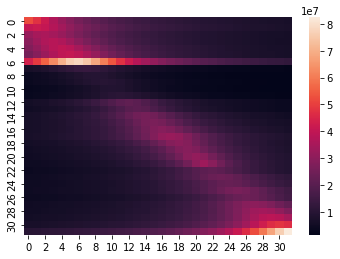

In [ ]:
# T mtx 
p1 = sns.heatmap(T)

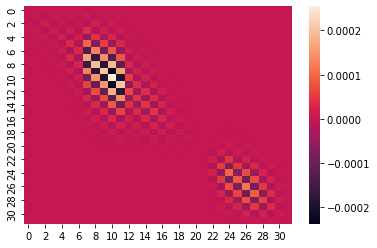

In [ ]:
# T inv mtx
T_inv = np.linalg.inv(T)
p = sns.heatmap(T_inv)

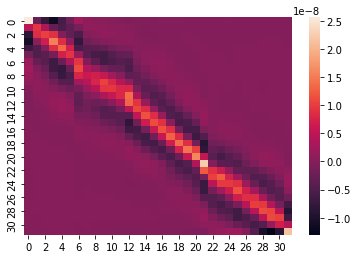

In [ ]:
# T_reg mtx
import seaborn as sns
p2 = sns.heatmap(T_reg)

#CSD

In [ ]:
csd = list(np.transpose(np.matmul(T_reg,V_ec)))
print(len(csd[0]))

32


# Integral - for each time instances

In [ ]:
M_P = []
M_P_from_soma = []
M_P_avg = []
M_P_avg_from_soma = []
surf_in_slice = [0]*len(novel[0])
surf_avg = [0]*len(novel[0])

# calculate total surfaces in slices
for part in Map:
  for i in range(len(Cell[part]['slice'])):
    s = Cell[part]['slice'][i]
    surf_in_slice[s] += Cell[part]['surface'][i]


for i in range(len(csd)):
  membrane_pot = []
  membrane_pot_from_soma = []
  membrane_pot_avg = [0]*len(novel[0])
  membrane_pot_from_soma_avg = [0]*len(novel[0])

  for part in Map:
    if part != 'CellBody':
      calculate_integral(Cell[part], csd[i], Vc[i])
  
  Cell["CellBody"]['first_integral'] = [0]
  Cell["CellBody"]['second_integral'] = [Vc[i]]
  
  Cell["CellBody"]['first_integral_from_soma'] = [Cell["CellBody"]['surface'][0] * csd[i][Cell["CellBody"]['slice'][0]]]
  Cell["CellBody"]['second_integral_from_soma'] = [Vc[i] + Cell["CellBody"]['resistance'][0] * Cell["CellBody"]['first_integral_from_soma'][0]]
  
  for part in Map:
    if part != 'CellBody':
      for i in range(len(Cell[part]["slice"])):
        C1 = Cell[part]["coords"][i]
        C2 = Cell[part]["coords"][i+1]
        S = Cell[part]["surface"][i]
        R = Cell[part]["resistance"][i]
        index = Cell[part]["slice"][i]
        integral2 = Cell[part]["second_integral"][i]
        integral2_from_soma = Cell[part]["second_integral_from_soma"][i]
        
        membrane_pot.append([C1, C2, integral2, index, S])
        membrane_pot_from_soma.append([C1, C2, integral2_from_soma, index, S]) #[koord1, koord2, Vm, slice_index, surface]

        membrane_pot_avg[index] += integral2 * S / surf_in_slice[index]
        membrane_pot_from_soma_avg[index] += integral2_from_soma * S / surf_in_slice[index]
    else:
      C1 = Cell[part]["coords"][0]
      integral2 = Cell[part]["second_integral"][0]
      integral2_from_soma = Cell[part]["second_integral_from_soma"][0]
      S = Cell[part]["surface"][0]
      index = Cell[part]["slice"][0]
      membrane_pot.append([C1, C1, integral2, index, S])
      membrane_pot_from_soma.append([C1, C1, integral2_from_soma, index, S]) #[koord1, koord2, Vm, slice_index, surface]

      membrane_pot_avg[index] += integral2 * S / surf_in_slice[index]
      membrane_pot_from_soma_avg[index] += integral2_from_soma * S / surf_in_slice[index]
  
  M_P.append(membrane_pot)
  M_P_from_soma.append(membrane_pot_from_soma)
  M_P_avg.append(membrane_pot_avg)
  M_P_avg_from_soma.append(membrane_pot_from_soma_avg)

  for part in Map:
    reset_cell(Cell[part])

<AxesSubplot:>

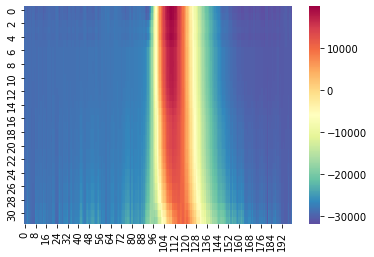

In [ ]:
M_P_avg_plot = np.transpose(np.array(M_P_avg))
sns.heatmap(M_P_avg_plot, cmap="Spectral_r")   #mV

In [ ]:
# 1. integrating convention
I_C = []

for i in range(len(M_P)-1):
  ic = []
  for j in range(len(M_P[i])):
    dVm = ((M_P[i+1][j][2] - M_P[i][j][2]) / (5 * 1e-5)) * capacity
    ic.append([M_P[i][j][0], M_P[i][j][1], dVm, M_P[i][j][3], M_P[i][j][4]])
    # [C1, C2, Ic, slice, surface]
  I_C.append(ic)

In [ ]:
# Heatmap
I_C_avg = []
for i in range(len(I_C)):
  ic_avg = [0] * len(novel[0])
  for j in range(len(I_C[i])):
    s = I_C[i][j][3] # slice index
    ic_avg[s] += I_C[i][j][2] * I_C[i][j][4]  # ic_avg 1*32 vector
  I_C_avg.append(ic_avg)       # ic_avg 199*32 mtx

<AxesSubplot:>

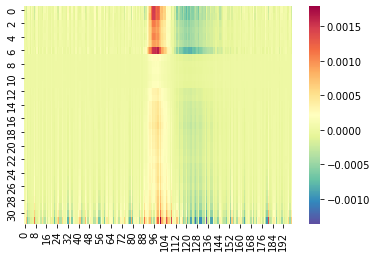

In [ ]:
I_C_avg_plot = np.transpose(np.array(I_C_avg))
sns.heatmap(I_C_avg_plot, cmap="Spectral_r")    #uA

<AxesSubplot:>

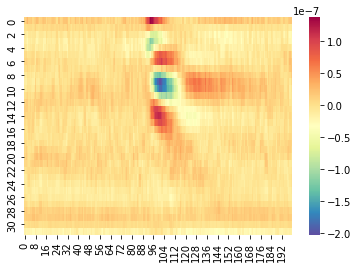

In [ ]:
CSD_avg_plot = np.transpose(np.array(csd))
sns.heatmap(CSD_avg_plot, cmap="Spectral_r")

In [ ]:
# CSD & I_m 
CSD_mtx = []
I_M = []
V_ec = np.transpose(V_ec)
V_EC = []
for i in range(len(M_P)-1):
  lst = []
  lst2 = []
  lst3 = []
  for j in range(len(M_P[i])): #in every time instance for every compartment
    s = M_P[i][j][3]
    lst.append([M_P[i][j][0], M_P[i][j][1], csd[i][s], M_P[i][j][3], M_P[i][j][4]])
    lst2.append([M_P[i][j][0], M_P[i][j][1], csd[i][s] * M_P[i][j][4], M_P[i][j][3], M_P[i][j][4]])
    lst3.append([M_P[i][j][0], M_P[i][j][1], V_ec[i][s], M_P[i][j][3], M_P[i][j][4]])
    # icsd : = [C1, C2, csd value in slice, slice, surface]
    # i_m : = [C1, C2, csd value in slice * surface, slice, surface]     
  CSD_mtx.append(lst)
  I_M.append(lst2)
  V_EC.append(lst3)

In [ ]:
#for generating heatmap data
I_M_avg = []
for i in range(len(I_M)):
  im_avg = [0] * len(novel[0])
  for j in range(len(I_M[i])):
    s = I_M[i][j][3] # slice index
    im_avg[s] += I_M[i][j][2]  # im_avg 1*32 vector
  I_M_avg.append(im_avg)       # I_M_avg 199*32 mtx

<AxesSubplot:>

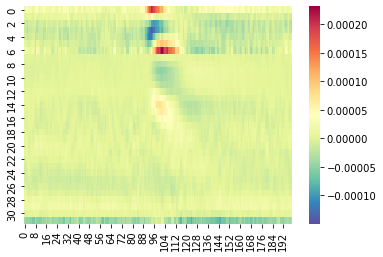

In [ ]:
I_M_avg_plot = np.transpose(np.array(I_M_avg))
sns.heatmap(I_M_avg_plot, cmap="Spectral_r") #uA

In [ ]:
I_R = []
for i in range(len(I_M)):
  lst = []
  for j in range(len(I_M[i])):
    lst.append([I_M[i][j][0], I_M[i][j][1], I_M[i][j][2]-I_C[i][j][2], I_M[i][j][3], I_M[i][j][4]])
    # [C1, C2, I_M-I_C in the slice, slice, surface]
  I_R.append(lst)

In [ ]:
# Heatmap
I_R_avg = []
for i in range(len(I_R)):
  ir_avg = [0] * len(novel[0])
  for j in range(len(I_R[i])):
    s = I_R[i][j][3] # slice index
    ir_avg[s] += I_R[i][j][2] # ic_avg 1*32 vector
  I_R_avg.append(ir_avg)       # ic_avg 199*32 mtx

<AxesSubplot:>

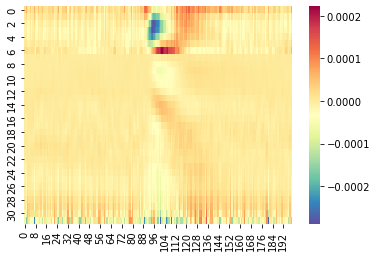

In [ ]:
I_R_avg_plot = np.transpose(np.array(I_R_avg))
sns.heatmap(I_R_avg_plot, cmap="Spectral_r") #uA

#Plotting
First of all we import a list of RGB colors, then scaled to global minimum and maximum values the given voltage or current data is represented.

In [ ]:
# read list of 90 rgb colors
def read_rgb90(filename):
  #90-es rgb list
  data, rgb90 = [], []
  for line in open(filename): 
    line = line.rstrip("").split(" ")
    for i in range(len(line)):
      line[i] = float(line[i])
    data.append(line)
  for i in range(len(data)):
    rgb90.append(data[i])
  rgb90 = rgb90[::-1]
  return rgb90

##Estimating membrane potential

In [ ]:
# color scale for membrane potential
def color_scale_V_M(V_min, V_max, V):
  if V < -30000: 
    return int(round((22 * (1/np.abs(V_min) * V) + 22), 3))
  if V >= -30000: 
    return int(round((24 * (1/V_max * V) + 24), 3))

# find maximal and minimal Voltage
def find_glob_extreme_V_M(M_P):
  vmin, vmax = 0, 0 
  V_min = M_P[0][0][2]
  V_max = M_P[0][0][2]  

  for t in range(len(M_P)):
    for d in range(len(M_P[t])):
        if M_P[t][d][2] < V_min:
          V_min = M_P[t][d][2]
          vmin = str(t) + "-" + str(d) + "-th compartment"
        if V_max < M_P[t][d][2]:
          V_max = M_P[t][d][2]
          vmax = str(t) + "-" + str(d) + "-th compartment" 
  V_min = min(min(Vc), V_min)
  V_max = max(max(Vc), V_max)
  print("V_max = " + str(V_max))
  print("V_min = " + str(V_min))
  print(vmin)
  print(vmax)
  return [V_min, V_max]

arg_mp = M_P
argstr_mp = "V_M"
colors = read_rgb90("RGBScale.txt")
colors = colors[40 :]
V_min, V_max = find_glob_extreme_V_M(arg_mp)

In [ ]:
#plotting membrane potential
plt.ioff()
x_soma = Cell["CellBody"]['coords'][0][0]
y_soma = Cell["CellBody"]['coords'][0][1]
z_soma = Cell["CellBody"]['coords'][0][2]
d_soma = Cell["CellBody"]['coords'][0][3]
for k in range(len(arg)):
  fig = plt.figure(figsize=(32,16))
  ax = plt.axes(projection='3d')
  ax.set_xlabel('X ($\mu m$)')
  ax.set_ylabel('Y ($\mu m$)')
  ax.set_zlabel('Z ($\mu m$)') 
  for mp in arg_mp[k]:
    x1 = mp[0][0]
    x2 = mp[1][0] 
    y1 = mp[0][1]
    y2 = mp[1][1]
    z1 = mp[0][2]
    z2 = mp[1][2]
    d1 = mp[0][3]
    d2 = mp[1][3]
    col = color_scale_V_M(V_min, V_max, mp[2])
    ax.scatter3D(x_soma, y_soma, z_soma, linewidth=d_soma, marker="*", color=colors[col])
    ax.plot3D([x1,x2], [y1,y2], [z1,z2], linewidth=2.5*(d1+d2)/2, c=colors[col])
  images_dir = 'sp9_snapshots/sp9_' + f"{argstr_mp}"
  if k < 100 and k >= 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr_mp}_0" + str(k+1), dpi=300)
  elif k < 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr_mp}_00" + str(k+1), dpi=300)
  else: fig.savefig(f"{images_dir}/sp9_" + f"{argstr_mp}_" + str(k+1), dpi=300) 
  plt.close(fig)

## Plotting functions

In [ ]:
# non-linear color scaling
def color_scale(V_min, V_max, V):
  if V <= 0: 
    return int(round((45 * np.cbrt(1/np.abs(V_min) * V) + 45), 4))
  if V > 0: 
    return int(round((44 * np.cbrt(1/np.abs(V_max) * V) + 44), 4))

# find maximal and minimal Values
def find_glob_extreme(M_P):
  vmin, vmax = 0, 0 
  V_min = M_P[0][0][2]
  V_max = M_P[0][0][2]  
  for t in range(len(M_P)):
    for d in range(len(M_P[t])):
        if M_P[t][d][2] < V_min:
          V_min = M_P[t][d][2]
          vmin = str(t) + "-" + str(d) + "-th compartment"
        if V_max < M_P[t][d][2]:
          V_max = M_P[t][d][2]
          vmax = str(t) + "-" + str(d) + "-th compartment"
  V_max=max(np.abs(V_max), np.abs(V_min))
  V_min= -V_max
  print("V_max = " + str(V_max))
  print("V_min = " + str(V_min))
  print(vmin)
  print(vmax)
  return [V_min, V_max]

Argument can be V_EC, CSD_mtx, I_M, I_R or I_C.

In [ ]:
arg = CSD_mtx
argstr = "siCSD"
colors = read_rgb90("RGBScale.txt")
V_min, V_max = find_glob_extreme(arg)

In [ ]:
#NEURON FROM A STRANGE PERSPECTIVE
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.ioff()
x_soma = Cell["CellBody"]['coords'][0][0]
y_soma = Cell["CellBody"]['coords'][0][1]
z_soma = Cell["CellBody"]['coords'][0][2]
d_soma = Cell["CellBody"]['coords'][0][3]
for k in range(len(arg)): #[94, 101, 127]:
  fig = plt.figure(figsize=(32,16))
  ax = plt.axes(projection='3d')
  #ax.view_init(0, -90)
  ax.set_xlabel('X ($\mu m$)')
  ax.set_ylabel('Y ($\mu m$)')
  ax.set_zlabel('Z ($\mu m$)')
  for mp in arg[k]:
    x1 = mp[0][0]
    x2 = mp[1][0] 
    y1 = mp[0][1]
    y2 = mp[1][1]
    z1 = mp[0][2]
    z2 = mp[1][2]
    d1 = mp[0][3]
    d2 = mp[1][3]
    col = color_scale(V_min, V_max, mp[2])
    ax.scatter3D(x_soma, y_soma, z_soma, linewidth=d_soma, marker="*", color=colors[col])
    ax.plot3D([x1,x2], [y1,y2], [z1,z2], linewidth=2.5*(d1+d2)/2, c=colors[col])
  images_dir = 'sp9_snapshots/sp9_' + f"{argstr}"
  if k < 100 and k >= 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr}_0" + str(k+1), dpi=300)
  elif k < 9: fig.savefig(f"{images_dir}/sp9_" + f"{argstr}_00" + str(k+1), dpi=300)
  else: fig.savefig(f"{images_dir}/sp9_" + f"{argstr}_" + str(k+1), dpi=300) 
  plt.close(fig)